In [1]:
import hist
import numpy as np
import os
from pathlib import Path
import sys

In [2]:
current_dir = Path.cwd()
pikls = current_dir / 'pikls' / 'AN_plot_processor_UL'
src = current_dir.parent.parent / 'src'

sys.path.append(str(src))
sys.path.append(str(pikls))

from analysis_tools.plotting.efficiencies import calc_eff_err

In [3]:
pikls_to_open = []
for file in pikls.iterdir():
    print(file)
    pikls_to_open.append(file)

/home/cms-jovyan/dwg_experimental/notebooks/new_AN_plots/pikls/AN_plot_processor_UL/TChiWZ_UL.pkl
/home/cms-jovyan/dwg_experimental/notebooks/new_AN_plots/pikls/AN_plot_processor_UL/TTtoDiJet.pkl


In [4]:
pikls_to_open

[PosixPath('/home/cms-jovyan/dwg_experimental/notebooks/new_AN_plots/pikls/AN_plot_processor_UL/TChiWZ_UL.pkl'),
 PosixPath('/home/cms-jovyan/dwg_experimental/notebooks/new_AN_plots/pikls/AN_plot_processor_UL/TTtoDiJet.pkl')]

In [5]:
import cloudpickle

results = {}

for file in pikls_to_open:
    with open(file, "rb") as f:
        result = cloudpickle.load(f)
        for key, value in result.items():
            print(key)
            results[key]=value

SMS-TChiWZ_ZToLL_mZMin-0p1_TuneCP5_13TeV-madgraphMLM-pythia8_2017UL
TTJets_DiLept_TuneCP5_13TeV-madgraphMLM-pythia8_2017UL


In [6]:
results.keys()

dict_keys(['SMS-TChiWZ_ZToLL_mZMin-0p1_TuneCP5_13TeV-madgraphMLM-pythia8_2017UL', 'TTJets_DiLept_TuneCP5_13TeV-madgraphMLM-pythia8_2017UL'])

In [7]:
list(results.keys())[0]

'SMS-TChiWZ_ZToLL_mZMin-0p1_TuneCP5_13TeV-madgraphMLM-pythia8_2017UL'

In [8]:
r = results[list(results.keys())[0]]

In [9]:
r

{'total_entries': 5028190,
 'ele_dict': {'pt_eta_hist': Hist(
    Variable([2, 3, 4, 5, 7, 10, 20, 45, 75, 1000], name='pt'),
    Variable([0, 0.8, 1.4442, 1.556, 2.5], name='eta'),
    IntCategory([-10, 10, 11, 12, 13], name='gen_tag'),
    IntCategory([-1, 1, 2, 3], name='qual_tag'),
    storage=Double()) # Sum: 3466618.0 (4082907.0 with flow),
  'pt_AN_hist_v1': Hist(
    Regular(40, 0, 100, name='pt'),
    IntCategory([-10, 10, 11, 12, 13], name='gen_tag'),
    IntCategory([-1, 1, 2, 3], name='qual_tag'),
    storage=Double()) # Sum: 4053276.0 (4082907.0 with flow),
  'pt_AN_hist_v2': Hist(
    Variable(array([  2. ,   3. ,   4. ,   5. ,   7. ,  10. ,  12.5,  15. ,  17.5,
          20. ,  22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,
          42.5,  45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,
          65. ,  67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,
          87.5,  90. ,  92.5,  95. ,  97.5, 100. ]), name='pt'),
    IntCategory([-10, 10, 11, 12, 

In [10]:
def make_plot_pt_ID(hist, title, num_events, sample_name, filename):
    plt.title(title, pad=35, fontsize=35)
    vmin = 0.0001
    vmax = 0.01
    

    # Normalize bin contents
    view = hist.view(flow=False)
    norm = view.sum()
    if norm > 0:
        hist.view(flow=False)[:] = view / norm  # overwrite in place

    mplhep.cms.label(loc=0, fontsize=20, com=13.6)
    plt.text(2.5, -0.8, f"numEvents = {num_events}", fontsize=15)
    plt.text(-0.5, 0, f"sample: {sample_name}", fontsize=13, rotation=90)
    
    #hist.plot2d(norm=colors.LogNorm(vmin=vmin, vmax=vmax))
    hist.plot2d(norm=colors.LogNorm(vmin=vmin, vmax=vmax))
    #hist.plot2d()

    plt.yticks(range(int(plt.ylim()[0]), int(plt.ylim()[1]) + 1, 2))
    plt.axhline(y=1.5, color='red', linestyle='--', linewidth=3)
    plt.savefig(f"plots/{filename}")
    plt.show()

In [11]:
def make_plot_pt_ID_v2(ax, hist, title, num_events, sample_name, horz_lin):
    vmin = 0.0001
    vmax = 0.01

    # Normalize bin contents
    view = hist.view(flow=False)
    norm = view.sum()
    if norm > 0:
        hist.view(flow=False)[:] = view / norm  # overwrite in place

    mplhep.cms.label(loc=0, fontsize=22, com=13.6, ax=ax)
    ax.set_title(title, pad=35, fontsize=35)
    ax.set_xlabel('LowPtElectron $p_T$ (GeV)')
    ax.text(2, -0.8, f"numEvents = {num_events}", fontsize=16, fontweight="bold")
    ax.text(-1.8, 0, f"{sample_name}", fontsize=15, rotation=90, fontweight="bold")
    ax.set_xticks(range(0, 20, 5))

    # Ensure this ax is current for plot2d (in case plot2d uses plt.gca())
    plt.sca(ax)
    hist.plot2d(norm=colors.LogNorm(vmin=vmin, vmax=vmax), ax=ax)

    # Y ticks every 2 units
    y0, y1 = ax.get_ylim()
    ax.set_yticks(range(int(y0), int(y1) + 1, 2))

    ax.axhline(y=horz_lin, color='red', linestyle='--', linewidth=3)

In [12]:
def two_d_eff_err(h_num, h_denom): # h_num and h_denom must have same binning in both dimensions

    eff_h = h_num/h_denom # Creating a histogram
    
    err_h = np.sqrt(eff_h.values() * (1 - eff_h.values())/ h_denom.values())

    return eff_h, err_h

In [13]:
def plot_eta_pt_eff_old(
    hist_num,
    hist_denom,
   title,
   source,
   sample_name="test",
   save_name="test",
   color="cividis",
   vmin=0, vmax=1,
   event_count=None
):

    fig, ax = plt.subplots(figsize=(20, 20))
    mplhep.style.use(mplhep.style.CMS)
    mplhep.cms.label(loc=0, fontsize=28, com=13.6)

    eff = two_d_eff_err(hist_num, hist_denom)
    
    
    pt_edges = hist_num.axes[0].edges
    pt_centers = [(pt_edges[i] + pt_edges[i+1])/2 for i in range(len(pt_edges) - 1)]
    
    eta_edges = hist_num.axes[1].edges
    eta_centers = [(eta_edges[i] + eta_edges[i+1])/2 for i in range(len(eta_edges) - 1)]
    eta_labels = [fr"{eta_edges[i]:.3g} $< \eta \leq$ {eta_edges[i+1]:.3g}" for i in range(len(eta_edges) - 1)]
    
    
    #"viridis", "plasma", "inferno", "magma", "cividis"
    #plt.imshow(hist, aspect='auto', origin='lower', norm=colors.LogNorm())
    plt.imshow(
    eff[0],
    aspect='auto',
    cmap=color,
    origin='lower',
    extent=[eta_edges[0], eta_edges[-1], pt_edges[0], pt_edges[-1]],
    vmin=vmin,    # minimum value for color scale
    vmax=vmax     # maximum value for color scale
    )
    
    plt.xticks(ticks=eta_centers, labels=eta_labels, fontsize=30)
    plt.yticks(fontsize=35)

    # Get the efficiency values and errors
    values = np.nan_to_num(eff[0], nan=0.0)
    errors = np.nan_to_num(eff[1], nan=0.0)
    
    # Calculate bin centers for both axes
    

    # Loop through each bin and add text
    for i in range(len(pt_centers)):
        for j in range(len(eta_centers)):
            val = values[i, j]
            err = errors[i, j]
            plt.text(eta_centers[j], pt_centers[i], 
                    f"{val:.3f} ± {err:.3f}", 
                    ha='center', va='center', 
                    color='white', fontsize=25,
                    path_effects=[
                    path_effects.Stroke(linewidth=2, foreground='black'),
                    path_effects.Normal()
            ])
    
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    plt.tick_params(axis='x', pad=15)
    plt.tick_params(axis='y', pad=15)

    plt.ylabel("Electron $p_T$", fontsize=50)
    plt.title(f"Electron {title} Eff.", fontsize = 60, pad=60)

    
    plt.text(-0.3, pt_edges[3], f"Sample: {sample_name} {source}", ha='center', rotation=90, va='center', color='black', fontsize=35)
    if event_count is not None:
        plt.text(-0.17, pt_edges[3], f"num Events: {event_count}", ha='center', rotation=90, va='center', color='black', fontsize=30)

    plt.colorbar()
    plt.savefig(f"plots/{save_name}")
    plt.show()

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep
mplhep.style.use(mplhep.style.CMS)
plt.figure()
mplhep.style.use(mplhep.style.CMS)

<Figure size 1000x1000 with 0 Axes>

In [15]:
r.keys()

dict_keys(['total_entries', 'ele_dict', 'muon_dict', 'lpte_dict'])

In [16]:
r['lpte_dict']['pt_ID_hist']

Hist(
  Regular(20, 0, 20, name='pt'),
  Regular(100, 0, 10, name='ID'),
  IntCategory([-10, 10, 11, 12, 13], name='gen_tag'),
  IntCategory([-1, 1, 2, 3], name='qual_tag'),
  storage=Double()) # Sum: 3169061.0 (3573617.0 with flow)

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f92af674fb0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f92ae6c8470>, text=[])

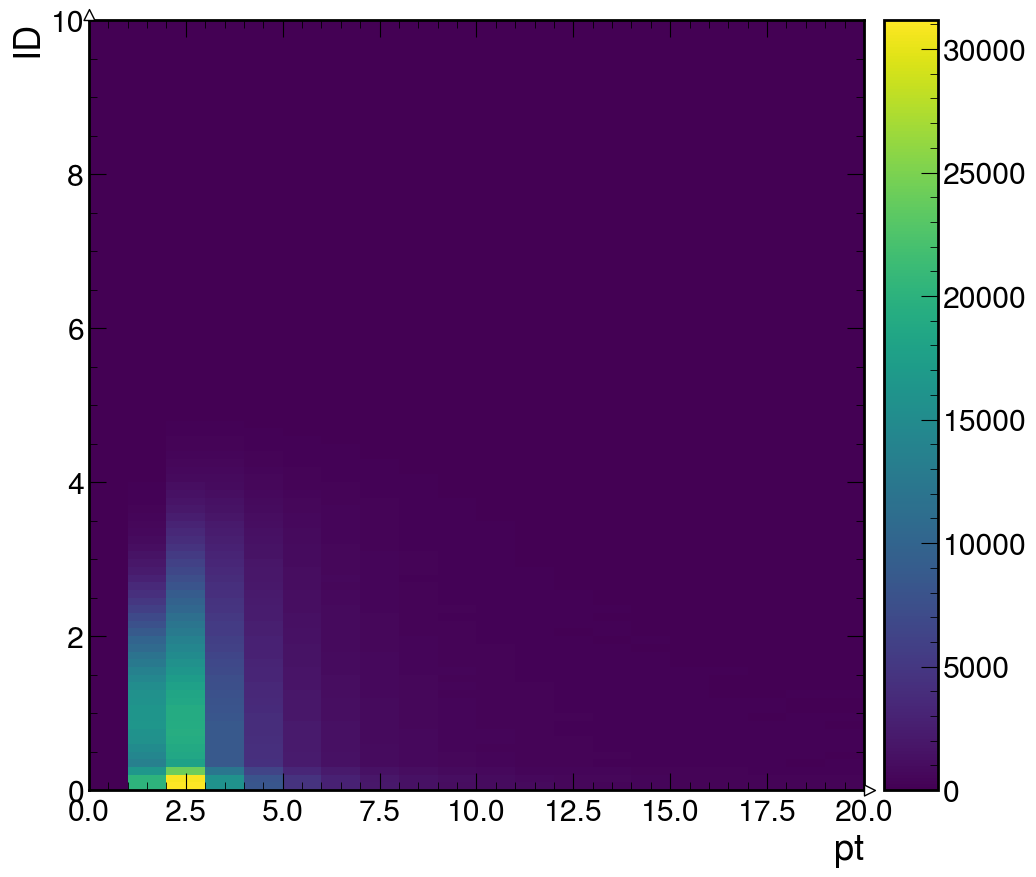

In [17]:
r['lpte_dict']['pt_ID_hist'].integrate("qual_tag")[:, :, 11j].plot()

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f92a5840ad0>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f92a585bb90>, text=[])

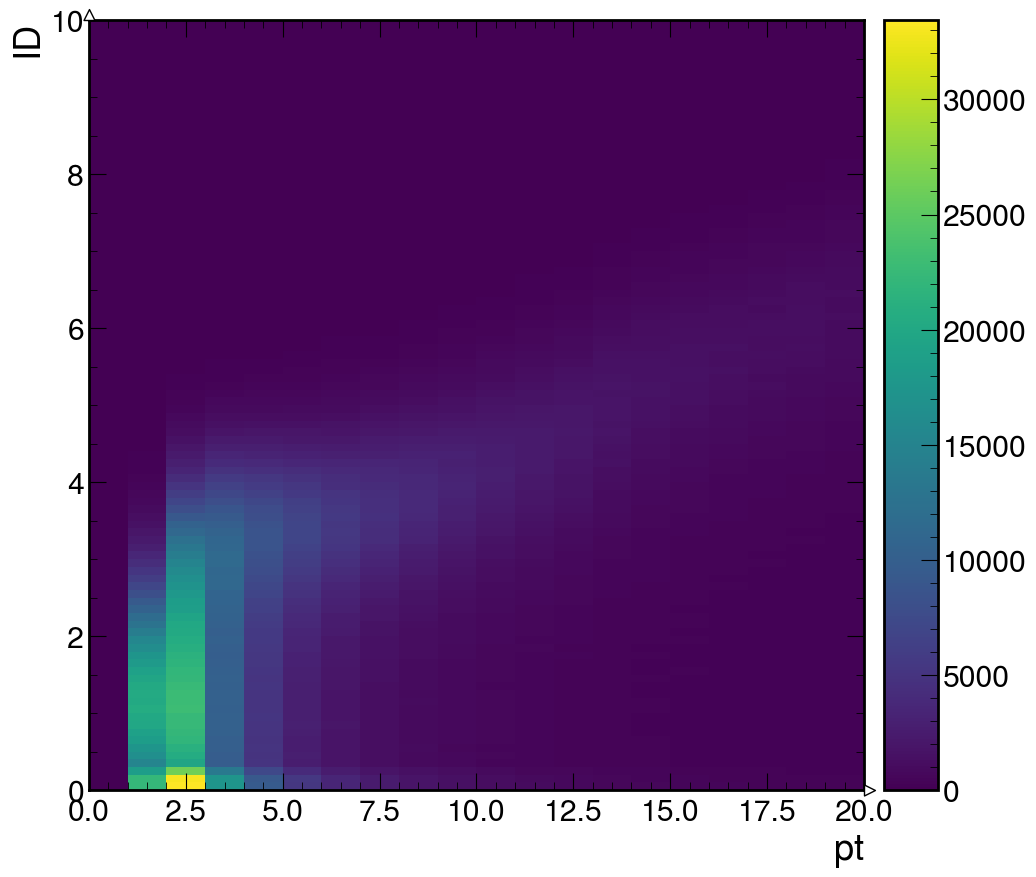

In [18]:
r['lpte_dict']['pt_ID_hist'].integrate("qual_tag").integrate("gen_tag").plot()


In [19]:
#make_plot_pt_ID_v2(ax, hist, title, num_events, sample_name, filename):

## 2023 SlepSnu270 vs ttbar

In [20]:
sig_name = list(results.keys())[0]
sig_name

'SMS-TChiWZ_ZToLL_mZMin-0p1_TuneCP5_13TeV-madgraphMLM-pythia8_2017UL'

In [21]:
bg_name = list(results.keys())[1]
bg_name

'TTJets_DiLept_TuneCP5_13TeV-madgraphMLM-pythia8_2017UL'

In [22]:
raw_signal_lpte_pt_ID = (
    results[sig_name]['lpte_dict']['pt_ID_hist'].integrate("qual_tag")[:,:, 10j]
)

In [23]:
raw_background_lpte_pt_ID = (
    results[bg_name]['lpte_dict']['pt_ID_hist'].integrate("qual_tag")[:,:, 11j]
)

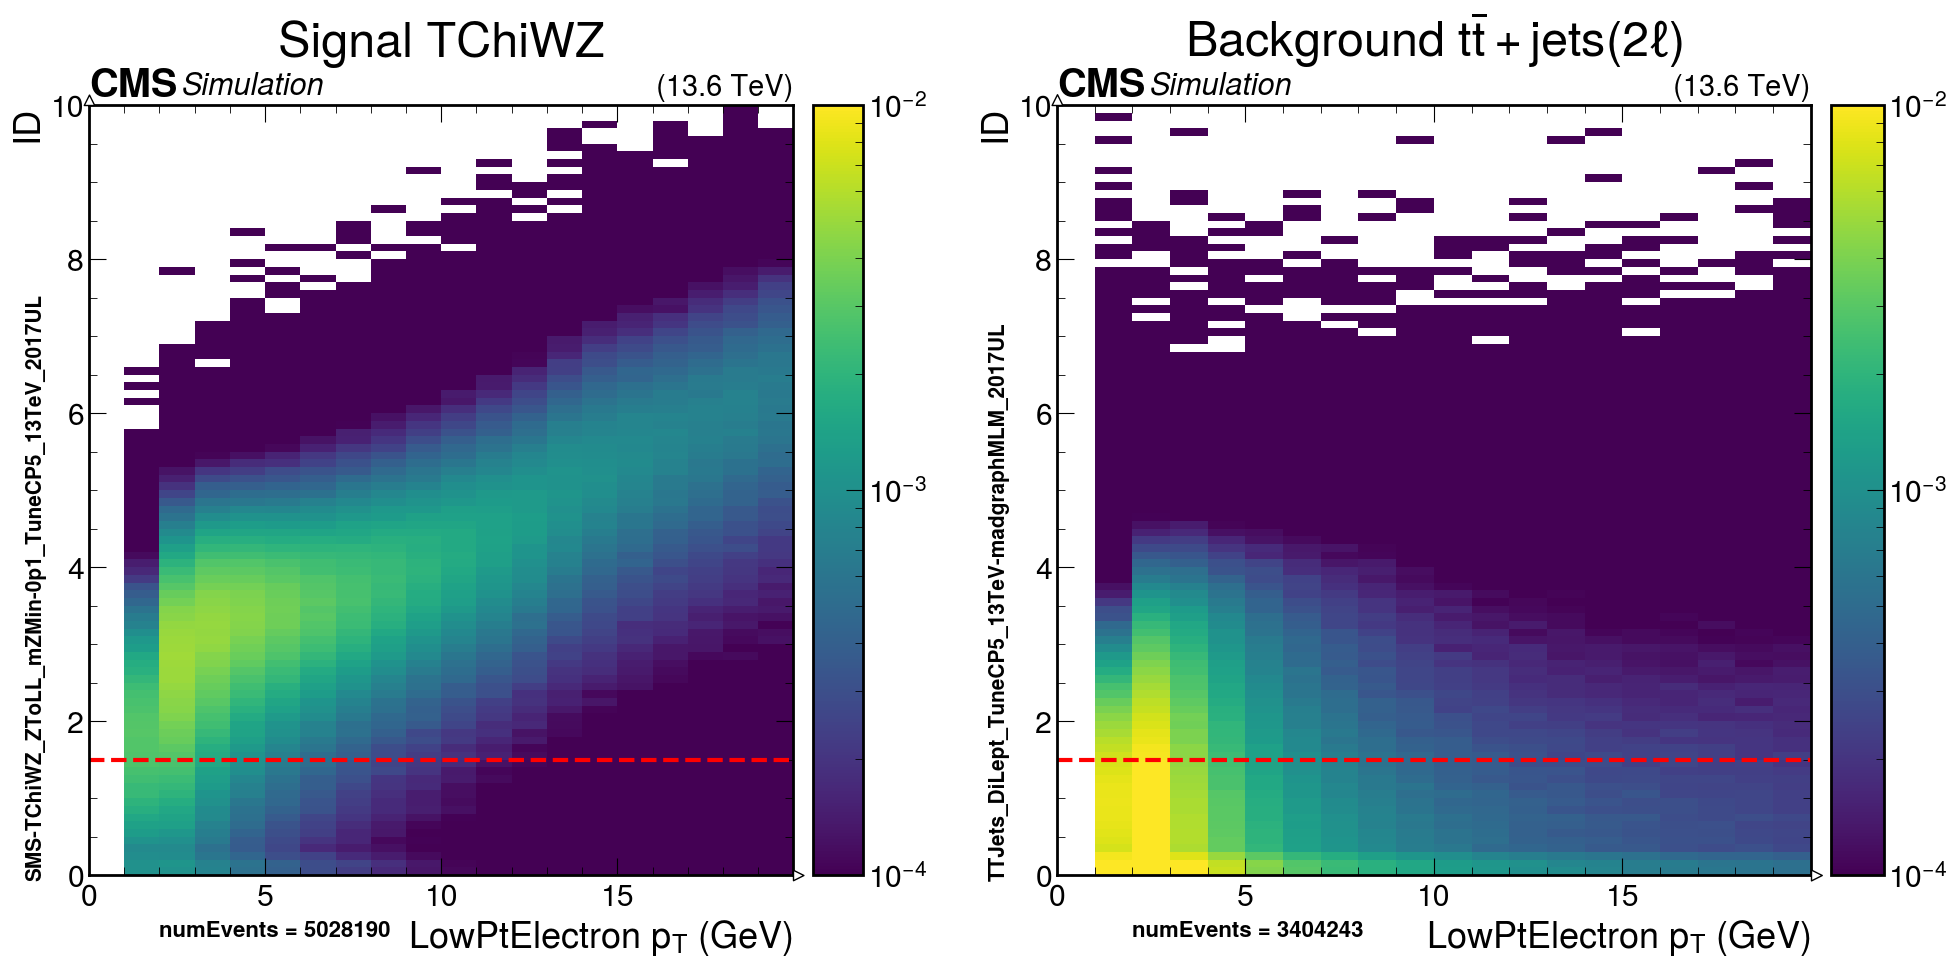

In [24]:
fig, axes = plt.subplots(1,2, figsize=(20,10))

make_plot_pt_ID_v2(
    axes[0],
    raw_signal_lpte_pt_ID,
    "Signal TChiWZ",
    results[sig_name]['total_entries'],
    sig_name[:40]+ "_2017UL",
    horz_lin=1.5
)

make_plot_pt_ID_v2(
    axes[1],
    raw_background_lpte_pt_ID,
    r"Background $t\overline{t}+jets(2\ell)$",
    results[bg_name]['total_entries'],
    bg_name[:39]+"_2017UL",
    horz_lin=1.5
)

fig.savefig('plots/ID_vs_pt_signal_vs_background_17UL.pdf')

In [25]:
results

{'SMS-TChiWZ_ZToLL_mZMin-0p1_TuneCP5_13TeV-madgraphMLM-pythia8_2017UL': {'total_entries': 5028190,
  'ele_dict': {'pt_eta_hist': Hist(
     Variable([2, 3, 4, 5, 7, 10, 20, 45, 75, 1000], name='pt'),
     Variable([0, 0.8, 1.4442, 1.556, 2.5], name='eta'),
     IntCategory([-10, 10, 11, 12, 13], name='gen_tag'),
     IntCategory([-1, 1, 2, 3], name='qual_tag'),
     storage=Double()) # Sum: 3466618.0 (4082907.0 with flow),
   'pt_AN_hist_v1': Hist(
     Regular(40, 0, 100, name='pt'),
     IntCategory([-10, 10, 11, 12, 13], name='gen_tag'),
     IntCategory([-1, 1, 2, 3], name='qual_tag'),
     storage=Double()) # Sum: 4053276.0 (4082907.0 with flow),
   'pt_AN_hist_v2': Hist(
     Variable(array([  2. ,   3. ,   4. ,   5. ,   7. ,  10. ,  12.5,  15. ,  17.5,
           20. ,  22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,
           42.5,  45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,
           65. ,  67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,
           

In [26]:
results.keys()

dict_keys(['SMS-TChiWZ_ZToLL_mZMin-0p1_TuneCP5_13TeV-madgraphMLM-pythia8_2017UL', 'TTJets_DiLept_TuneCP5_13TeV-madgraphMLM-pythia8_2017UL'])

In [27]:
results[list(results.keys())[0]]

{'total_entries': 5028190,
 'ele_dict': {'pt_eta_hist': Hist(
    Variable([2, 3, 4, 5, 7, 10, 20, 45, 75, 1000], name='pt'),
    Variable([0, 0.8, 1.4442, 1.556, 2.5], name='eta'),
    IntCategory([-10, 10, 11, 12, 13], name='gen_tag'),
    IntCategory([-1, 1, 2, 3], name='qual_tag'),
    storage=Double()) # Sum: 3466618.0 (4082907.0 with flow),
  'pt_AN_hist_v1': Hist(
    Regular(40, 0, 100, name='pt'),
    IntCategory([-10, 10, 11, 12, 13], name='gen_tag'),
    IntCategory([-1, 1, 2, 3], name='qual_tag'),
    storage=Double()) # Sum: 4053276.0 (4082907.0 with flow),
  'pt_AN_hist_v2': Hist(
    Variable(array([  2. ,   3. ,   4. ,   5. ,   7. ,  10. ,  12.5,  15. ,  17.5,
          20. ,  22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,
          42.5,  45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,
          65. ,  67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,
          87.5,  90. ,  92.5,  95. ,  97.5, 100. ]), name='pt'),
    IntCategory([-10, 10, 11, 12, 

In [28]:
results[list(results.keys())[0]].keys()

dict_keys(['total_entries', 'ele_dict', 'muon_dict', 'lpte_dict'])

In [29]:
results[list(results.keys())[0]]['lpte_dict'].keys()

dict_keys(['pt_eta_hist', 'pt_ID_hist'])

In [30]:
results[list(results.keys())[0]]['lpte_dict']['pt_eta_hist']

Hist(
  Variable([1, 2, 3, 4, 5, 7, 10, 20, 45, 75, 1000], name='pt'),
  Variable([0, 0.8, 1.4442, 1.556, 2.5], name='eta'),
  IntCategory([-10, 10, 11, 12, 13], name='gen_tag'),
  IntCategory([-1, 1, 2, 3], name='qual_tag'),
  storage=Double()) # Sum: 3408396.0 (3573617.0 with flow)

In [31]:
#signal_pt_hist_v1[:, 10j, 3j]

In [32]:
"""
def plot_eta_pt_eff_v2(
    hist_num,
    hist_denom,
   title,
   source,
   sample_name="test",
   save_name="test",
   color="cividis",
   vmin=0, vmax=1,
   event_count=None
):
"""

'\ndef plot_eta_pt_eff_v2(\n    hist_num,\n    hist_denom,\n   title,\n   source,\n   sample_name="test",\n   save_name="test",\n   color="cividis",\n   vmin=0, vmax=1,\n   event_count=None\n):\n'

ColormeshArtists(pcolormesh=<matplotlib.collections.QuadMesh object at 0x7f92a4338b30>, cbar=<matplotlib.colorbar.Colorbar object at 0x7f92a4251fa0>, text=[])

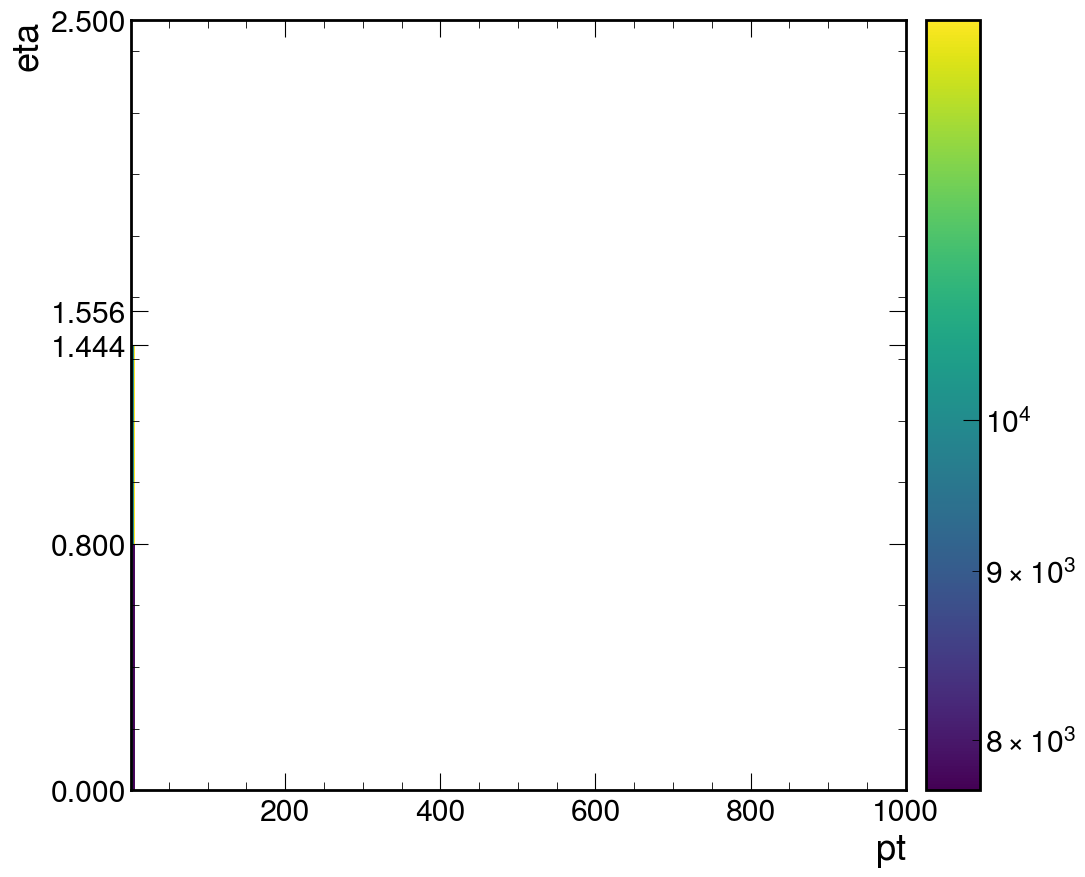

In [33]:
results[list(results.keys())[0]]['lpte_dict']['pt_eta_hist'][:,:, 10j, 1j].plot(norm=colors.LogNorm())

In [34]:
signal_gold = results[list(results.keys())[0]]['lpte_dict']['pt_eta_hist'][:,:, 10j, 3j]
signal_baseline = results[list(results.keys())[0]]['lpte_dict']['pt_eta_hist'].integrate("qual_tag", [1j,2j,3j])[:,:,10j]
signal_baseline.axes

(Variable([1, 2, 3, 4, 5, 7, 10, 20, 45, 75, 1000], name='pt'),
 Variable([0, 0.8, 1.4442, 1.556, 2.5], name='eta'))

In [35]:
def plot_eta_pt_eff_v2(
    hist_num,
    hist_denom,
   title,
   source,
   sample_name="test",
   save_name="test",
   color="cividis",
   vmin=0, vmax=1,
   event_count=None
):
    
    import matplotlib.patheffects as path_effects
    
    fig, ax = plt.subplots(figsize=(20, 20))
    mplhep.style.use(mplhep.style.CMS)
    mplhep.cms.label(loc=0, fontsize=35, com=13.6)

    eff = two_d_eff_err(hist_num, hist_denom)
    print(eff)

    pt_edges = hist_num.axes['pt'].edges
    pt_labels = [fr"{pt_edges[i]:.3g} - {pt_edges[i+1]:.3g}" for i in range(len(pt_edges) - 1)]
    pt_range = range(len(pt_edges))
    print(pt_edges)
    print(pt_labels)
    print(pt_range)
    
    eta_edges = hist_num.axes['eta'].edges
    eta_labels = [fr"{eta_edges[i]:.3g} $< |\eta| \leq$ {eta_edges[i+1]:.3g}" for i in range(len(eta_edges) - 1)]
    eta_range = range(len(eta_edges))
    print(eta_edges)
    print(eta_labels)
    print(eta_range)
    
    plt.imshow(
    eff[0],
    aspect='auto',
    cmap=color,
    origin='lower',
    #extent=[eta_edges[0], eta_edges[-1], pt_edges[0], pt_edges[-1]],
    vmin=vmin,    # minimum value for color scale
    vmax=vmax     # maximum value for color scale
    )
    
    
    plt.xticks(ticks=range(len(eta_labels)), labels=eta_labels, fontsize=30)
    plt.yticks(ticks=range(len(pt_labels)), labels=pt_labels, fontsize=30)
    
    # Get the efficiency values and errors
    values = np.nan_to_num(eff[0], nan=0.0)
    errors = np.nan_to_num(eff[1], nan=0.0)

    for i in range(len(pt_labels)):
        for j in range(len(eta_labels)):
            val = values[i, j]
            err = errors[i, j]
            plt.text(j, i, 
                    f"{val:.3f} ± {err:.3f}", 
                    ha='center', va='center', 
                    color='white', fontsize=25,
                    path_effects=[
                    path_effects.Stroke(linewidth=2, foreground='black'),
                    path_effects.Normal()
            ])
    
    
    
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    plt.tick_params(axis='x', pad=15)
    plt.tick_params(axis='y', pad=15)

    plt.ylabel("$p_T$ (GeV)", fontsize=50)
    plt.title(f"{title} Eff.", fontsize = 60, pad=60)

    
    plt.text(-1.3, 2, f"Sample: {sample_name} {source}", ha='center', rotation=90, va='center', color='black', fontsize=35)
    if event_count is not None:
        plt.text(-1, 2, f"num Events: {event_count}", ha='center', rotation=90, va='center', color='black', fontsize=35)

    
    plt.colorbar()
    plt.savefig(f"plots/{save_name}", bbox_inches="tight")
    plt.show()

(Hist(
  Variable([1, 2, 3, 4, 5, 7, 10, 20, 45, 75, 1000], name='pt'),
  Variable([0, 0.8, 1.4442, 1.556, 2.5], name='eta'),
  storage=Double()) # Sum: nan (nan with flow), array([[       nan,        nan,        nan,        nan],
       [0.00161304, 0.00337692,        nan,        nan],
       [0.00171376, 0.0031724 ,        nan,        nan],
       [0.0018217 , 0.00327292,        nan,        nan],
       [0.00123272, 0.00240854,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan]]))
[   1.    2.    3.    4.    5.    7.   10.   20.   45.   75. 1000.]
['1 - 2', '2 - 3', '3 - 4', '4 - 5', '5 - 7', '7 - 10', '10 - 20', '20 - 45', '45 - 75', '75 - 1e+03']
range(0, 11)
[0.     0.8    1.4442 1.556  2.5   ]
['0 $< |\\eta| \\leq$ 0.8', '0.8 

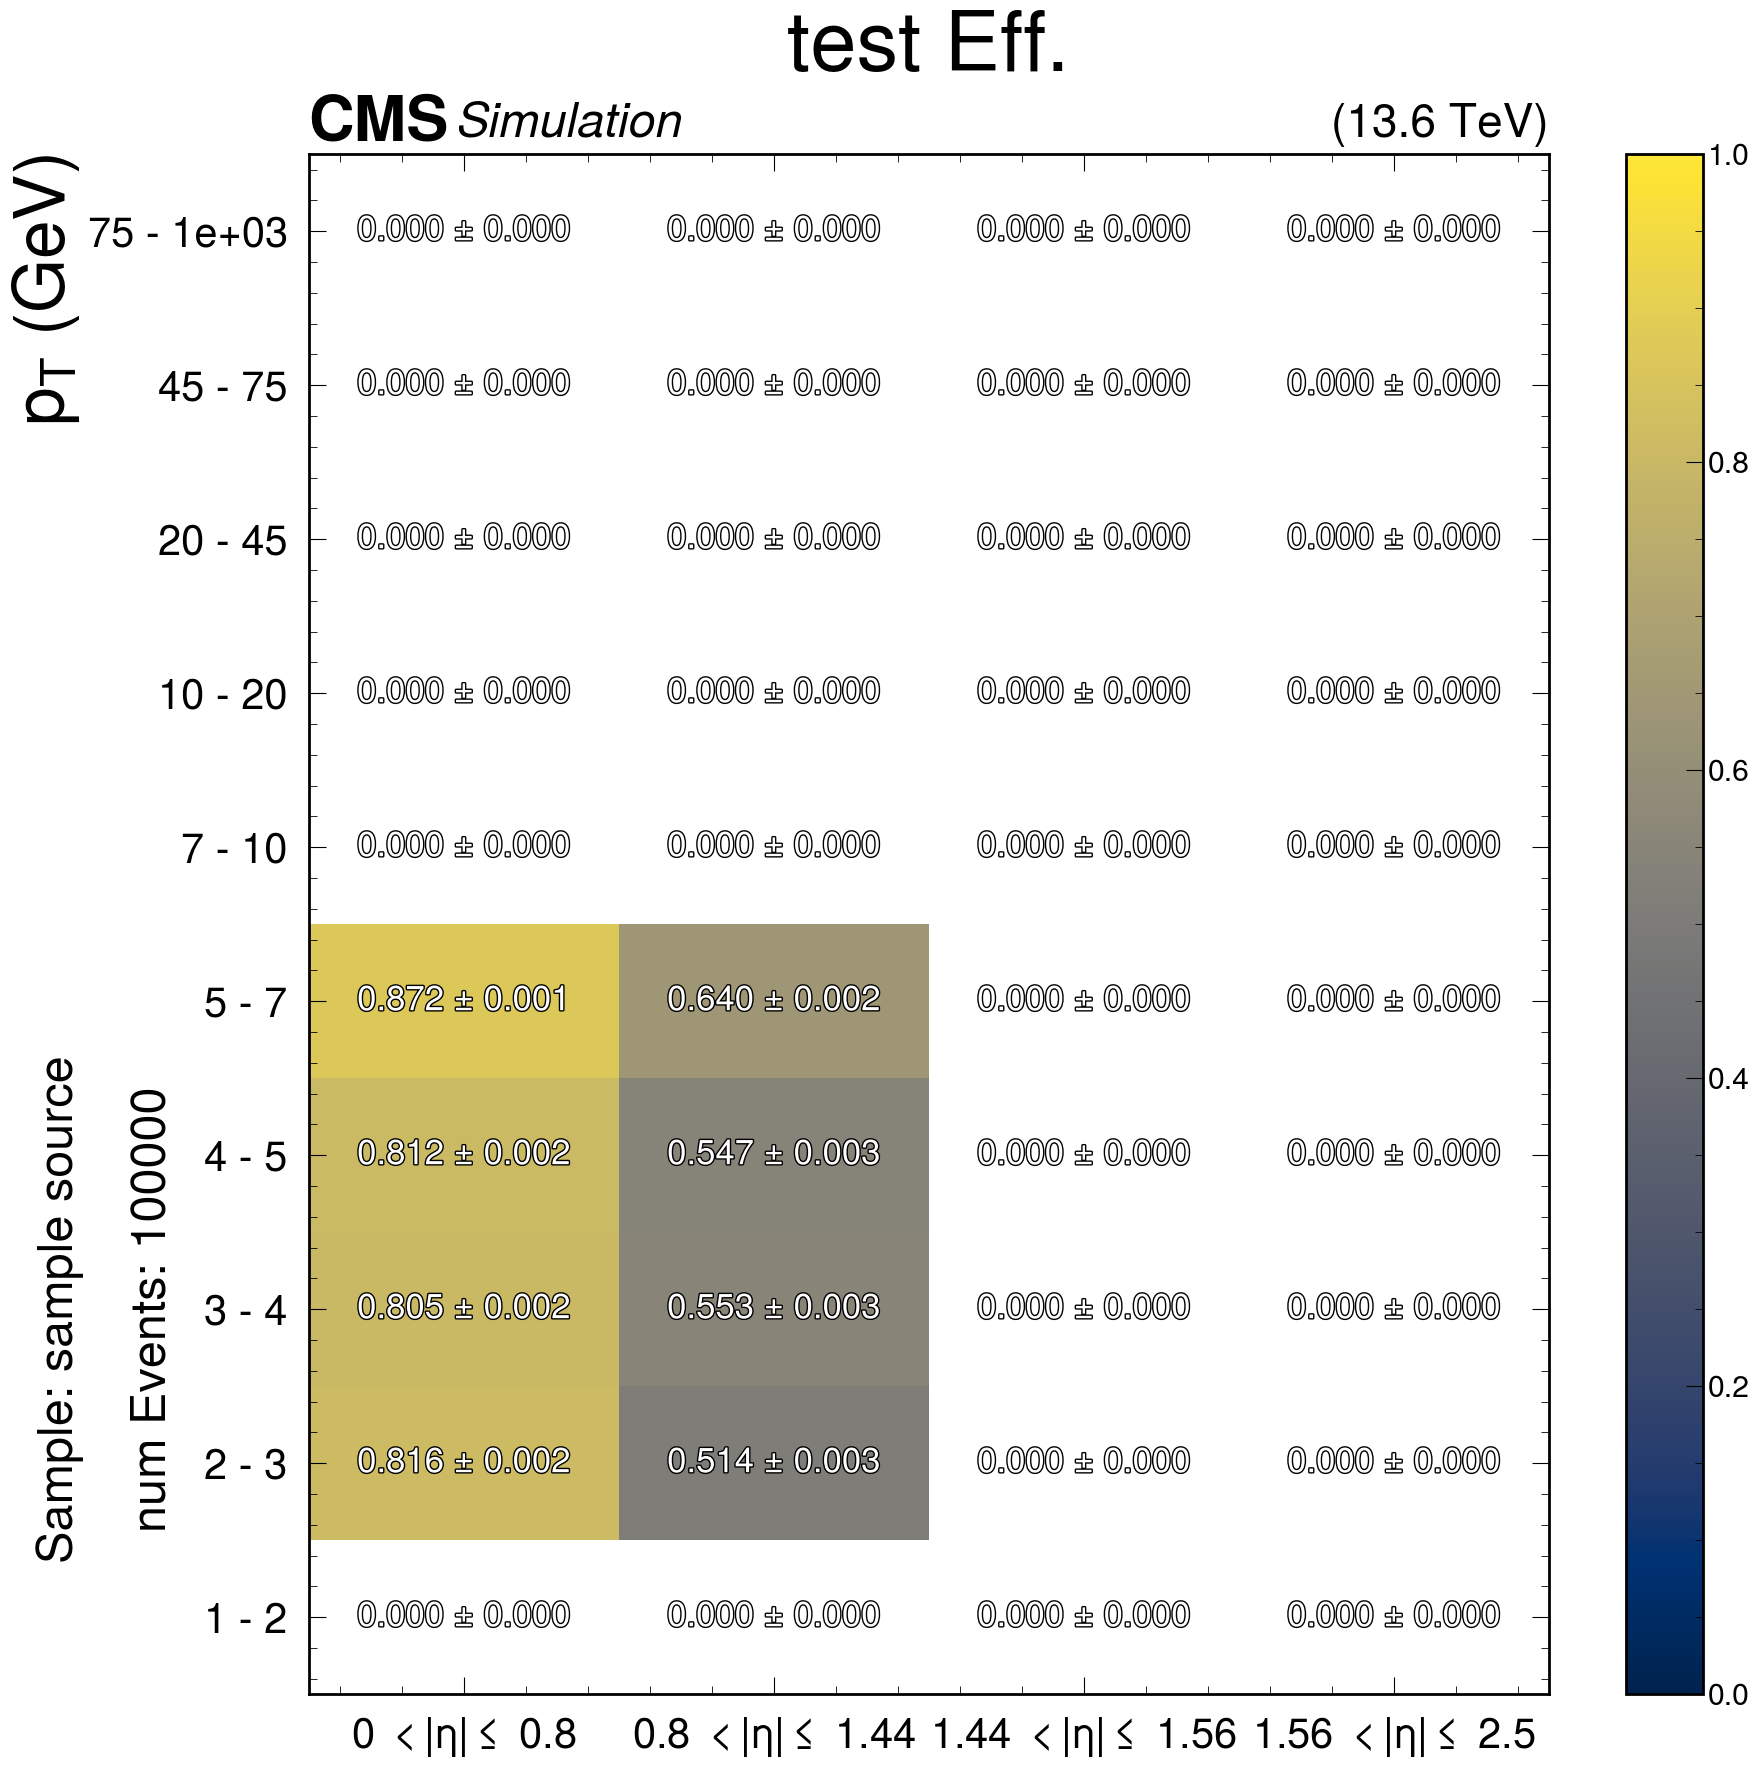

In [36]:
plot_eta_pt_eff_v2(
    signal_gold, 
    signal_baseline, 
    title="test",
    source="source",
    sample_name="sample",
    save_name="save_test",
    color="cividis",
    vmin=0, vmax=1,
    event_count=100000
)

In [37]:
signal_gold.axes['pt']

Variable([1, 2, 3, 4, 5, 7, 10, 20, 45, 75, 1000], name='pt')

(Hist(
  Variable([2, 3, 4, 5, 7, 10, 20, 45, 75, 1000], name='pt'),
  Variable([0, 0.8, 1.4442, 1.556, 2.5], name='eta'),
  storage=Double()) # Sum: nan (nan with flow), array([[0.00161304, 0.00337692,        nan,        nan],
       [0.00171376, 0.0031724 ,        nan,        nan],
       [0.0018217 , 0.00327292,        nan,        nan],
       [0.00123272, 0.00240854,        nan,        nan],
       [0.00232518, 0.00293293,        nan,        nan],
       [0.00121562, 0.00168086, 0.00593539, 0.00209092],
       [0.00090552, 0.0012456 , 0.00484123, 0.00177137],
       [0.00189741, 0.00273734, 0.01245795, 0.00424335],
       [0.00368342, 0.00576297, 0.02656125, 0.01066587]]))
[   2.    3.    4.    5.    7.   10.   20.   45.   75. 1000.]
['2 - 3', '3 - 4', '4 - 5', '5 - 7', '7 - 10', '10 - 20', '20 - 45', '45 - 75', '75 - 1e+03']
range(0, 10)
[0.     0.8    1.4442 1.556  2.5   ]
['0 $< |\\eta| \\leq$ 0.8', '0.8 $< |\\eta| \\leq$ 1.44', '1.44 $< |\\eta| \\leq$ 1.56', '1.56 $< |\\eta| \\

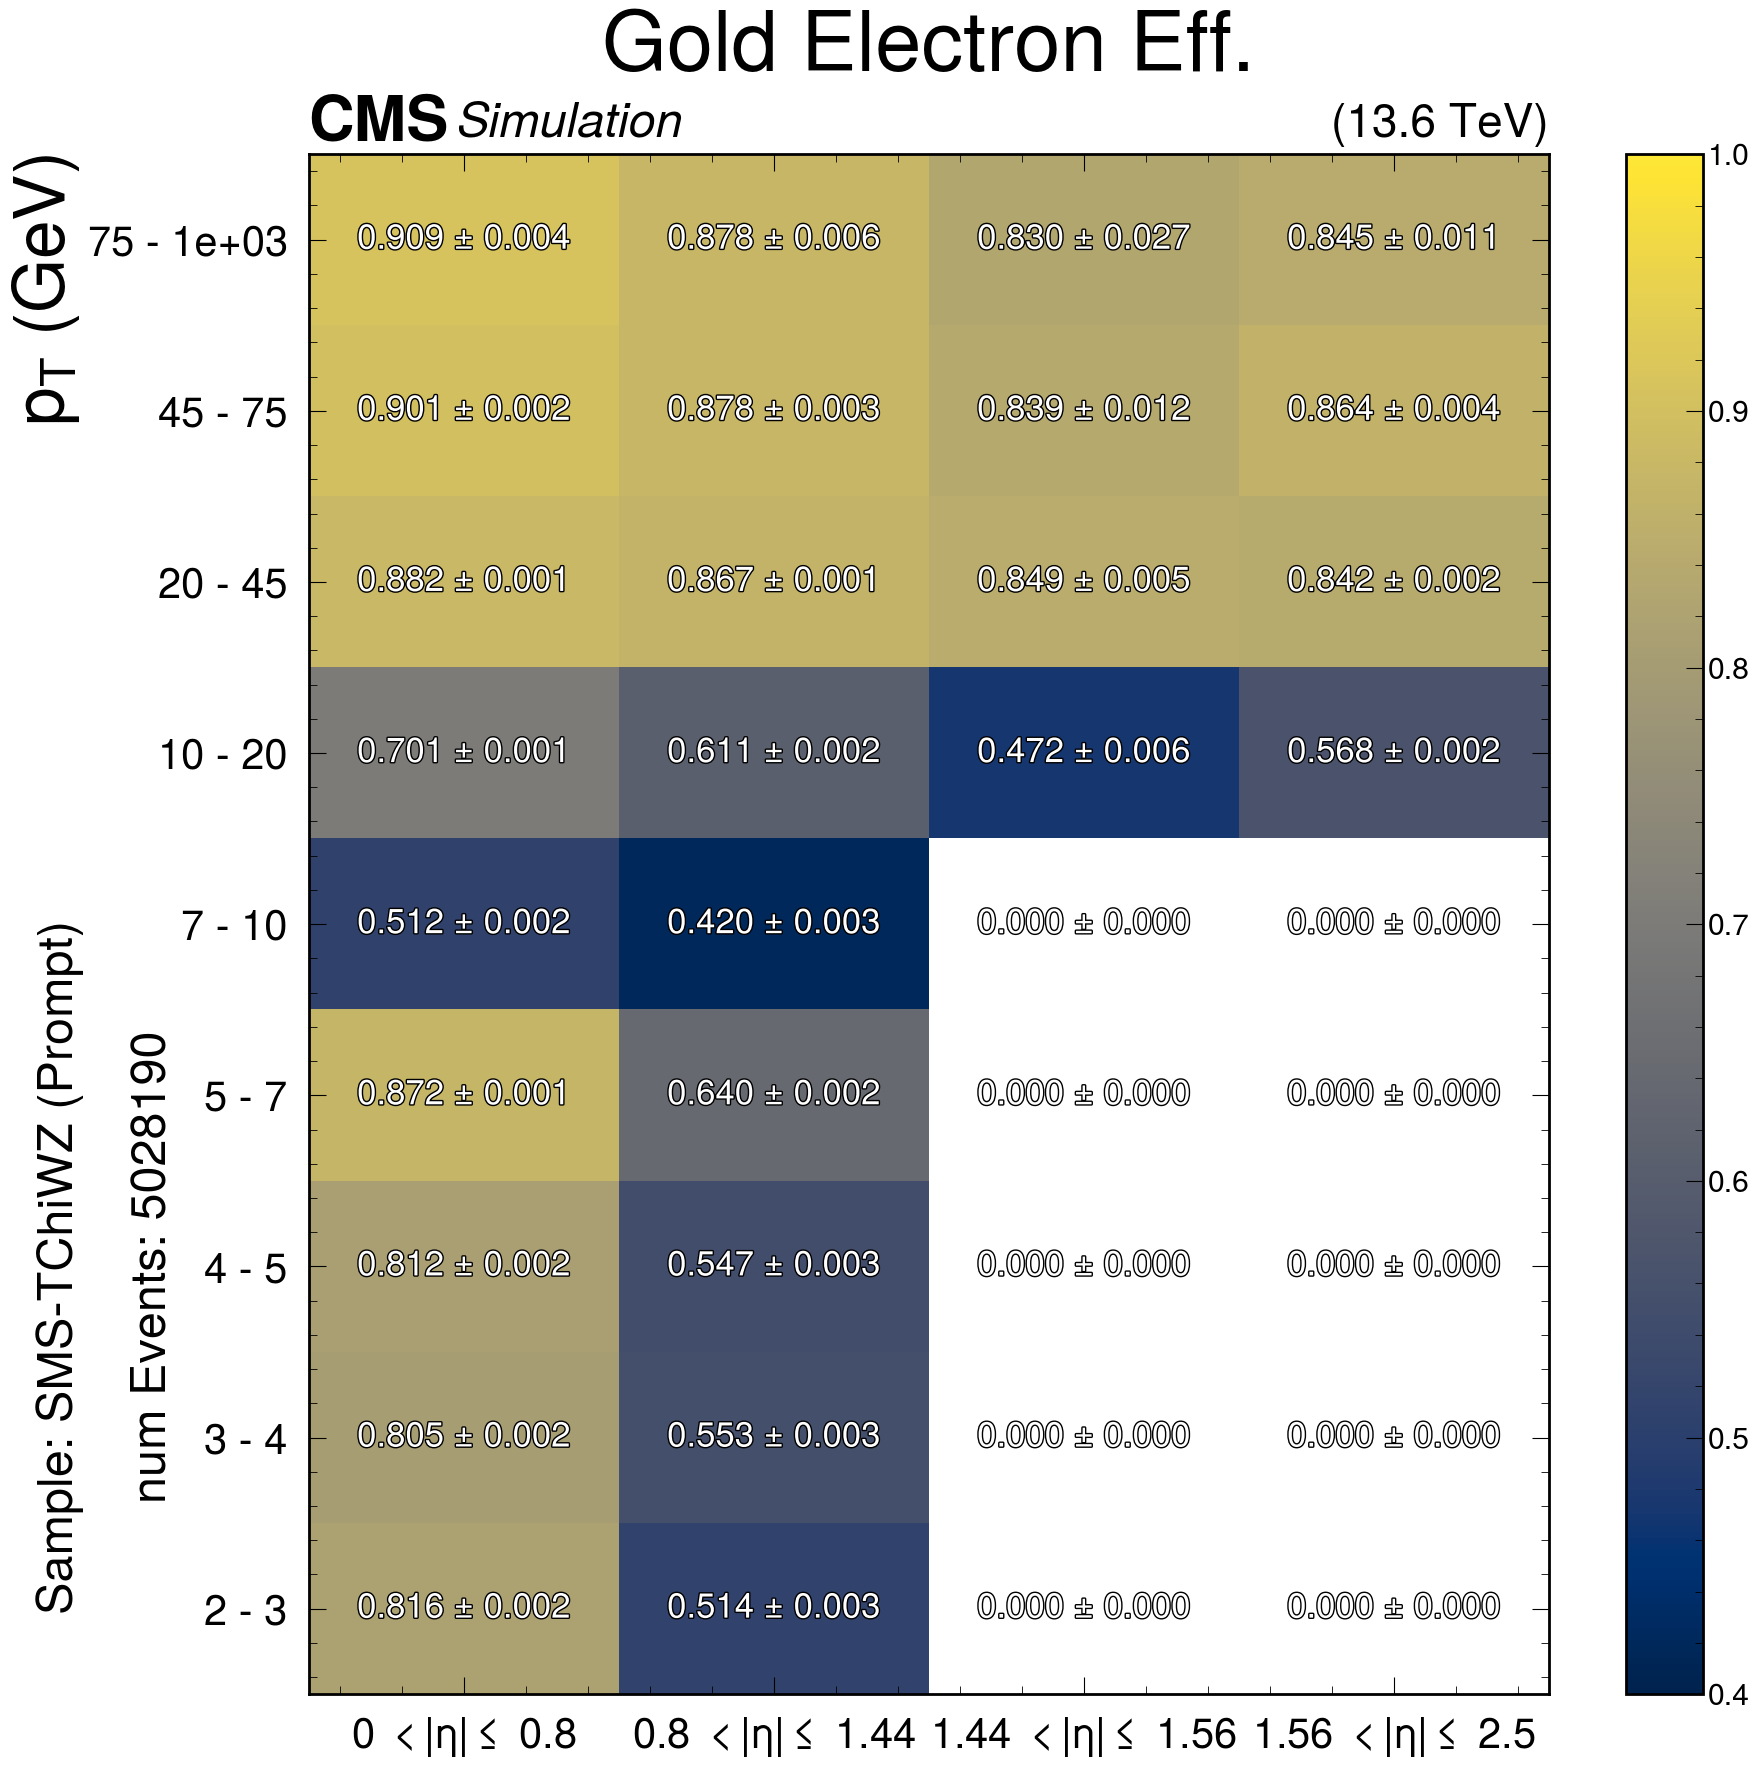

In [38]:
test_gold = results[list(results.keys())[0]]['ele_dict']['pt_eta_hist'][:,:, 10j, 3j]
test_baseline = results[list(results.keys())[0]]['ele_dict']['pt_eta_hist'].integrate("qual_tag", [1j,2j,3j])[:,:,10j]

plot_eta_pt_eff_v2(
    test_gold, 
    test_baseline, 
    title="Gold Electron",
    source="(Prompt)",
    sample_name=list(results.keys())[0][:10],
    save_name="save_test",
    color="cividis",
    vmin=0.4, vmax=1,
    event_count=results[list(results.keys())[0]]['total_entries']
)

(Hist(
  Variable([1, 2, 3, 4, 5, 7, 10, 20, 45, 75, 1000], name='pt'),
  Variable([0, 0.8, 1.4442, 1.556, 2.5], name='eta'),
  storage=Double()) # Sum: nan (nan with flow), array([[       nan,        nan,        nan,        nan],
       [0.00161304, 0.00337692,        nan,        nan],
       [0.00171376, 0.0031724 ,        nan,        nan],
       [0.0018217 , 0.00327292,        nan,        nan],
       [0.00123272, 0.00240854,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan]]))
[   1.    2.    3.    4.    5.    7.   10.   20.   45.   75. 1000.]
['1 - 2', '2 - 3', '3 - 4', '4 - 5', '5 - 7', '7 - 10', '10 - 20', '20 - 45', '45 - 75', '75 - 1e+03']
range(0, 11)
[0.     0.8    1.4442 1.556  2.5   ]
['0 $< |\\eta| \\leq$ 0.8', '0.8 

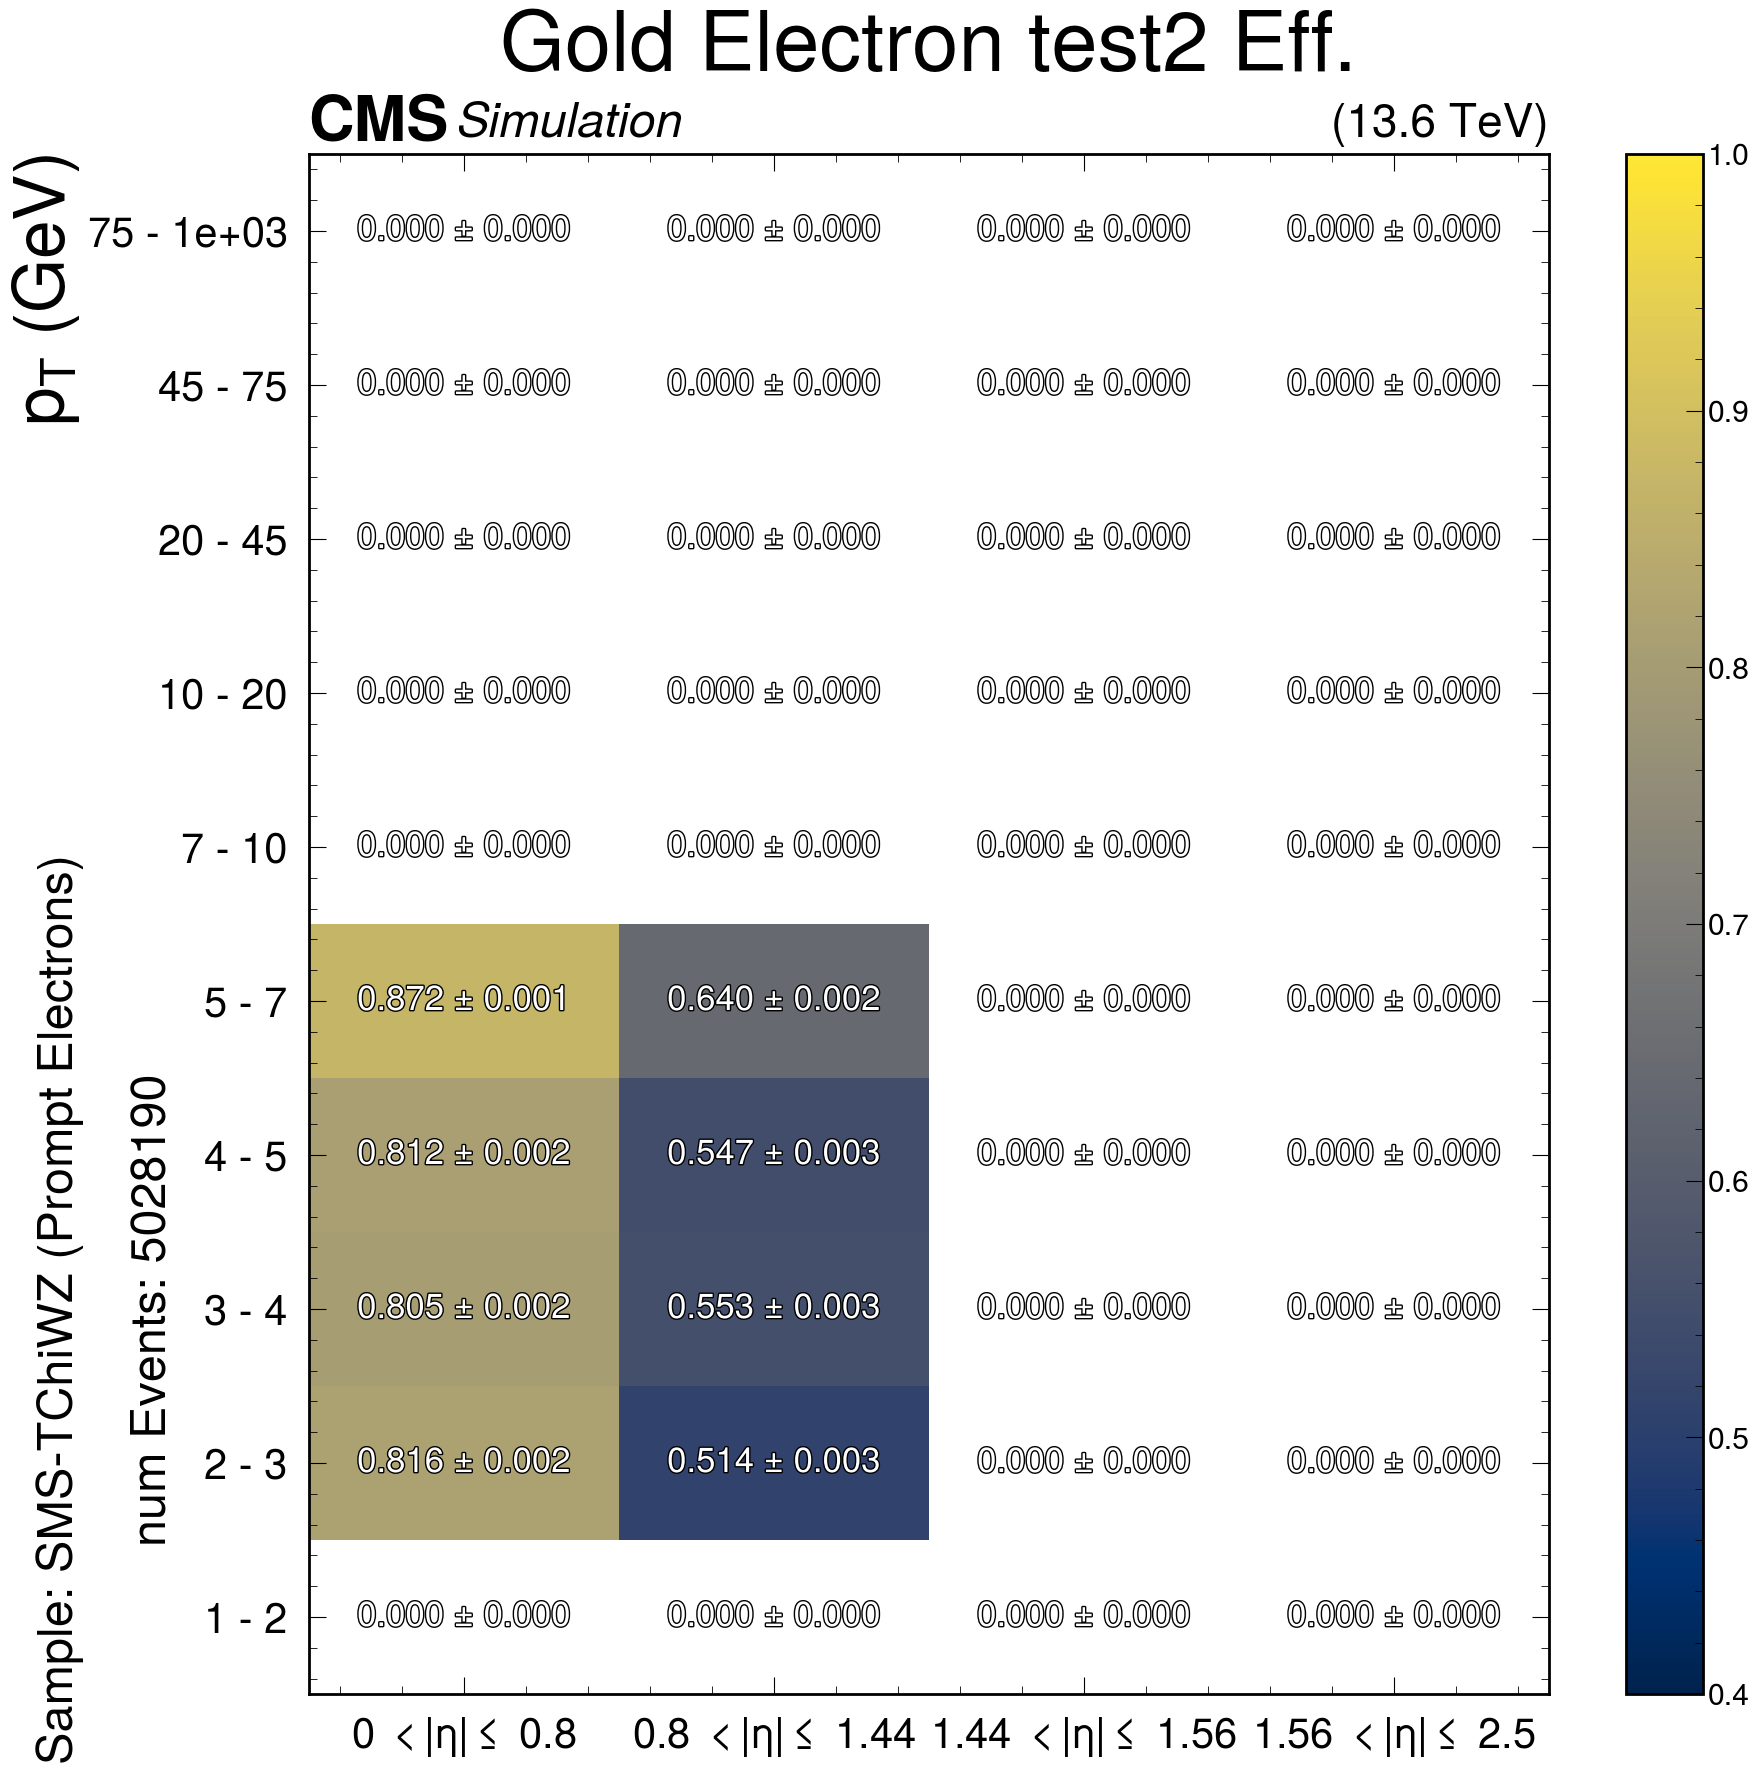

In [39]:
signal_gold = results[list(results.keys())[0]]['lpte_dict']['pt_eta_hist'][:,:, 10j, 3j]
signal_bl = results[list(results.keys())[0]]['lpte_dict']['pt_eta_hist'].integrate("qual_tag", [1j,2j,3j])[:,:,10j]

plot_eta_pt_eff_v2(
    signal_gold, 
    signal_bl,
    title="Gold Electron test2",
    source="(Prompt Electrons)",
    sample_name=list(results.keys())[0][:10],
    save_name="test2_efficiencies_TChiWZ_prompt",
    color="cividis",
    vmin=0.4, vmax=1,
    event_count=results[list(results.keys())[0]]['total_entries']
)

(Hist(
  Variable([1, 2, 3, 4, 5, 7, 10, 20, 45, 75, 1000], name='pt'),
  Variable([0, 0.8, 1.4442, 1.556, 2.5], name='eta'),
  storage=Double()) # Sum: nan (nan with flow), array([[       nan,        nan,        nan,        nan],
       [0.00671677, 0.00406803,        nan,        nan],
       [0.00814588, 0.00434391,        nan,        nan],
       [0.0101759 , 0.00494829,        nan,        nan],
       [0.00942013, 0.00588204,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan],
       [       nan,        nan,        nan,        nan]]))
[   1.    2.    3.    4.    5.    7.   10.   20.   45.   75. 1000.]
['1 - 2', '2 - 3', '3 - 4', '4 - 5', '5 - 7', '7 - 10', '10 - 20', '20 - 45', '45 - 75', '75 - 1e+03']
range(0, 11)
[0.     0.8    1.4442 1.556  2.5   ]
['0 $< |\\eta| \\leq$ 0.8', '0.8 

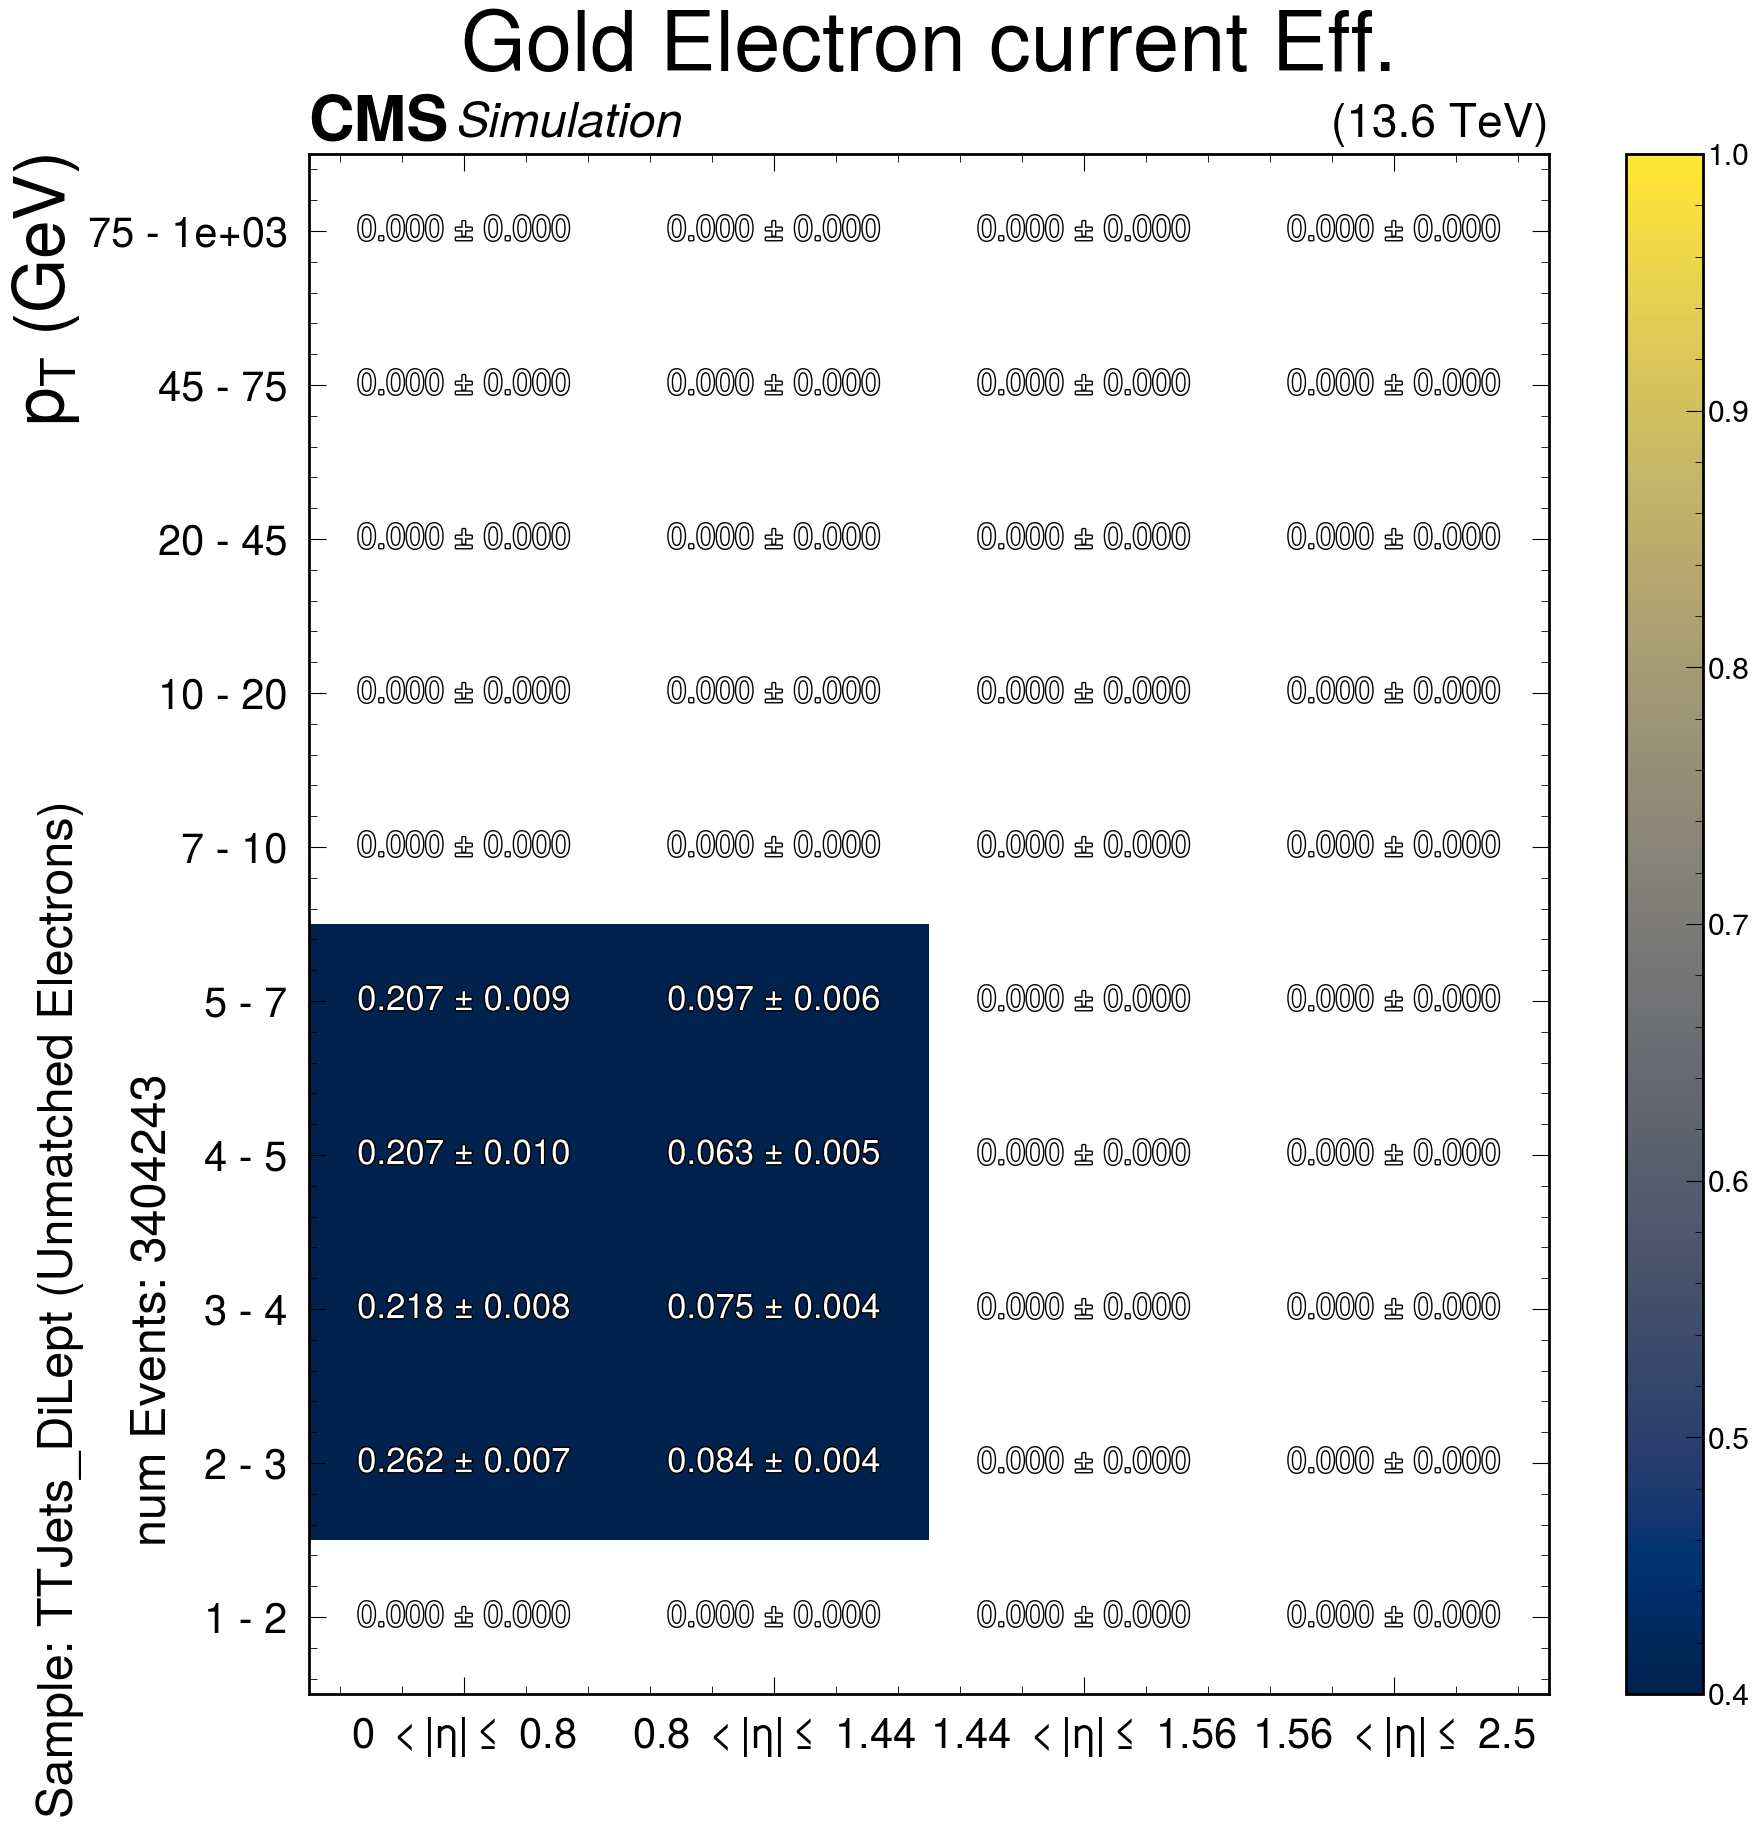

In [40]:
bg_gold = results[list(results.keys())[1]]['lpte_dict']['pt_eta_hist'][:,:, 11j, 3j]
bg_bl = results[list(results.keys())[1]]['lpte_dict']['pt_eta_hist'].integrate("qual_tag", [1j,2j,3j])[:,:,11j]

plot_eta_pt_eff_v2(
    bg_gold, 
    bg_bl,
    title="Gold Electron current",
    source="(Unmatched Electrons)",
    sample_name=list(results.keys())[1][:13],
    save_name="current_efficiencies_TTDiJets_unmatched",
    color="cividis",
    vmin=0.4, vmax=1,
    event_count=results[list(results.keys())[1]]['total_entries']
)

In [41]:
def make_AN_1d_pt_frac(signal, fakes, name="default_name", title=None, plot_txt=None, savefig=False):

    from matplotlib.lines import Line2D

    fig, ax = plt.subplots(figsize=(16.5, 12))

    sig_gold = signal[:, 10j, 3j] #10j corresponds to my assignment in gen_tagger, 10 == signal (from PV) and other requirements
    sig_silver = signal[:, 10j, 2j]
    sig_bronze = signal[:, 10j, 1j]
    sig_baseline = signal.integrate("qual_tag", [1j,2j,3j])[:, 10j]

    fake_gold = fakes[:, 11j, 3j] #11j corresponds to my assignment in gen_tagger, 11 == light fake (unmatched to PV)
    fake_silver = fakes[:, 11j, 2j]
    fake_bronze = fakes[:, 11j, 1j]
    fake_baseline = fakes.integrate("qual_tag", [1j,2j,3j])[:, 11j]

    
    sig_gold_eff_err = calc_eff_err(sig_gold, sig_baseline) 
    sig_silver_eff_err = calc_eff_err(sig_silver, sig_baseline)
    sig_bronze_eff_err = calc_eff_err(sig_bronze, sig_baseline)

    fake_gold_eff_err = calc_eff_err(fake_gold, fake_baseline)
    fake_silver_eff_err = calc_eff_err(fake_silver, fake_baseline)
    fake_bronze_eff_err = calc_eff_err(fake_bronze, fake_baseline)
    
    ax.set_ylim(0.01,1)
    ax.set_xlim(1,100)
    #ax.set_xscale('log')
    ax.set_yscale('log')

    edges = signal.axes[0].edges
    
    xes = (edges[:-1] + edges[1:]) * 0.5
    
    my_ms = 14
    my_cs = 75
    
    #plt.errorbar(2.5, y=sig_gold_eff_err[0], yerr=sig_gold_eff_err[1], fmt='o', markersize=my_ms, capsize=my_cs, color='darkorange')
    
    plt.errorbar(xes, y=sig_gold_eff_err[0], yerr=sig_gold_eff_err[1], fmt='o', markersize=my_ms, capsize=my_cs, color='darkorange')
    plt.errorbar(xes, y=sig_silver_eff_err[0], yerr=sig_silver_eff_err[1], fmt='o', markersize=my_ms, capsize=my_cs, color='dodgerblue')
    plt.errorbar(xes, y=sig_bronze_eff_err[0], yerr=sig_bronze_eff_err[1], fmt='o', markersize=my_ms, capsize=my_cs, color='firebrick')
    
    plt.errorbar(xes, y=fake_gold_eff_err[0], yerr=fake_gold_eff_err[1], fmt='s', mfc='none', markersize=my_ms, capsize=my_cs, color='darkorange')
    plt.errorbar(xes, y=fake_silver_eff_err[0], yerr=fake_silver_eff_err[1], fmt='s', mfc='none', markersize=my_ms, capsize=my_cs, color='dodgerblue')
    plt.errorbar(xes, y=fake_bronze_eff_err[0], yerr=fake_bronze_eff_err[1], fmt='s', mfc='none', markersize=my_ms, capsize=my_cs, color='firebrick')

    print(edges[0])
    print(edges[-1])
    plt.xlim(edges[0], edges[-1])
    #plt.xticks([20,40,60,80], fontsize=40)
    plt.xticks(fontsize=40)
    plt.xlabel("Electron $p_T$ [GeV]", fontsize=40)

    plt.tick_params(axis='y', which='both', right=True, labelright=True, size=20)
    
    plt.ylim(0, 1.46)
    plt.yticks(fontsize=40)
    plt.ylabel("Fraction of Baseline Selection", fontsize=35)
    #ax.set_ylabel("Efficiency", fontsize=40, labelpad=10)
    

    plt.grid(visible=None, which='major', axis='both', linewidth=2.0, alpha=1)
    
    #plt.axvline(x=5, color='#404040', linestyle='--', linewidth=2)
    mplhep.cms.text(" Work in Progress", loc=0, fontsize=30)
    

    if plot_txt is not None:
        plt.text(edges[-2], 1.46, plot_txt,
                 fontsize=30,
                 #fontname="Arial",
                 color='black',
                 #fontweight='bold',
                 ha='center',
                 va='bottom',
                 rotation=0)

    if title is not None:
        plt.title(title, fontsize=50, pad=55)

    handles = [
        Line2D([0], [0], marker='s', color='brown', label='Bronze', markersize=25, linestyle=''),
        Line2D([0], [0], marker='s', color='dodgerblue', label='Silver', markersize=25, linestyle=''),
        Line2D([0], [0], marker='s', color='darkorange', label='Gold', markersize=25, linestyle=''),
        Line2D([0], [0], marker='o', color='black', label='Prompt', markersize=my_ms, linestyle=''),
        Line2D([0], [0], marker='s', color='black', label='Misidentified', mfc='none', markersize=my_ms, linestyle='')
    ]
    
    #fig.legend(loc='lower center', fontsize=25, ncol=3, bbox_to_anchor=(0.5, -0.05))
    fig.legend(
    handles=handles,
    loc='upper left',
    #bbox_to_anchor=(0.2, 0.85),  # position in figure coordinates
    #bbox_to_anchor=(0.15, 0.08),  # position in figure coordinates
    bbox_to_anchor=(0.15, 0.05),
    fontsize=30,
    ncol=2,
    frameon=True,
    facecolor='white',
    edgecolor='black',
    framealpha=1
    )

    if savefig:
        plt.savefig(f"frac_plot_{name}.pdf", bbox_inches='tight')
    return fig, ax

/home/cms-jovyan/dwg_experimental/src/analysis_tools/plotting/efficiencies.py:41: RuntimeWarning: invalid value encountered in divide
  eff = num/denom
/tmp/ipykernel_4191/4116135836.py:57: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1.46)


1.0
7.0


(<Figure size 1650x1200 with 1 Axes>,
 <Axes: title={'center': 'Electron Fractional Compostion (test1)'}, xlabel='Electron $p_T$ [GeV]', ylabel='Fraction of Baseline Selection'>)

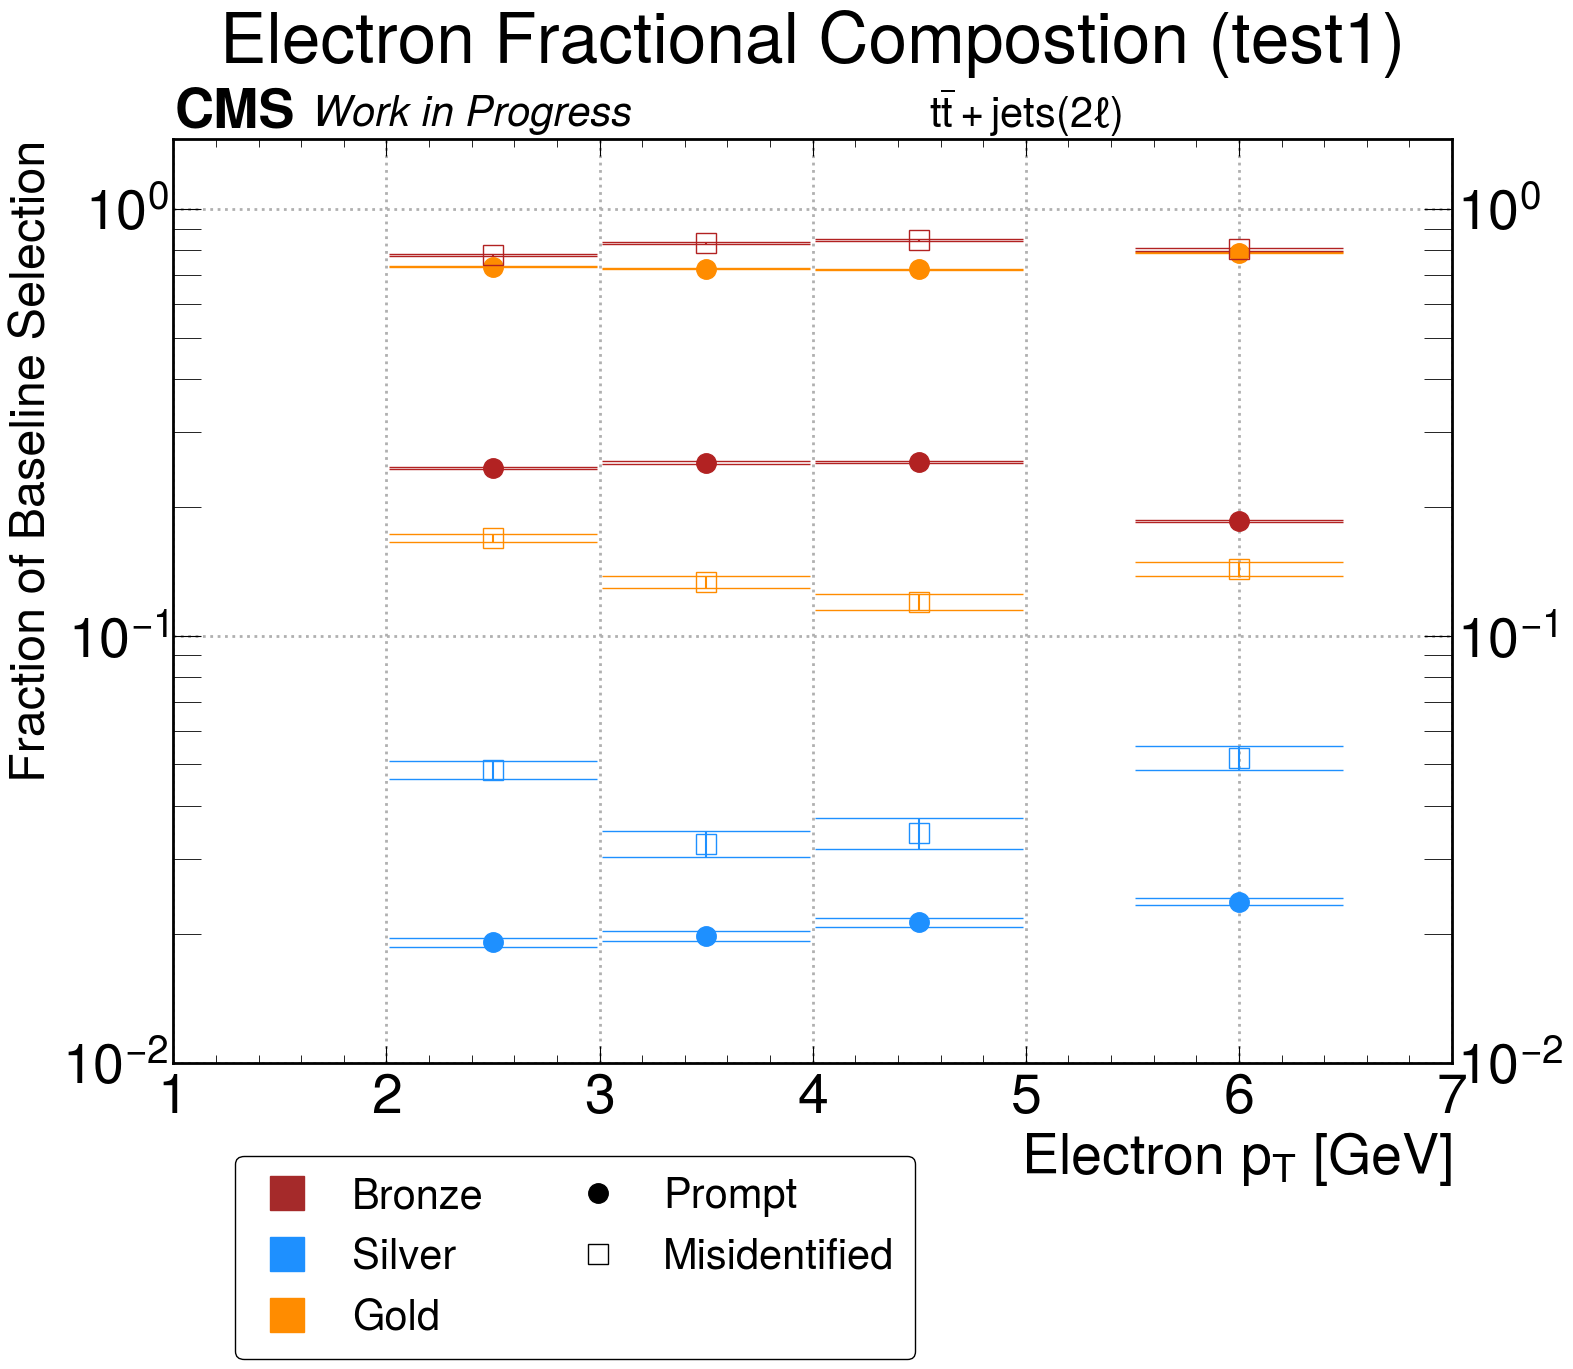

In [42]:
signal_hist = results[list(results.keys())[0]]['lpte_dict']['pt_eta_hist'].integrate("eta")
fakes_hist = results[list(results.keys())[1]]['lpte_dict']['pt_eta_hist'].integrate("eta")


make_AN_1d_pt_frac(
    signal_hist[:5, :, :],
    fakes_hist[:5, :, :],
    title="Electron Fractional Compostion (test1)",
    name="TChiWZ_sig_TTtoDiJets_fake_test1_UL",
    plot_txt = r"$t\overline{t} + jets (2\ell)$",
    savefig=True
)

In [43]:
def plot_eta_pt_counts(
    hist,
    title,
    source,
    sample_name="test",
    save_name="test",
    color="cividis",
    vmin=0, vmax=1,
    event_count=None
):
    
    import matplotlib.patheffects as path_effects
    
    fig, ax = plt.subplots(figsize=(20, 20))
    mplhep.style.use(mplhep.style.CMS)
    mplhep.cms.label(loc=0, fontsize=35, com=13.6)


    pt_edges = hist.axes['pt'].edges
    pt_labels = [fr"{pt_edges[i]:.3g} - {pt_edges[i+1]:.3g}" for i in range(len(pt_edges) - 1)]
    pt_range = range(len(pt_edges))
    print(pt_edges)
    print(pt_labels)
    print(pt_range)
    
    eta_edges = hist.axes['eta'].edges
    eta_labels = [fr"{eta_edges[i]:.3g} $< |\eta| \leq$ {eta_edges[i+1]:.3g}" for i in range(len(eta_edges) - 1)]
    eta_range = range(len(eta_edges))
    print(eta_edges)
    print(eta_labels)
    print(eta_range)

    # Get the values for text display in the bins
    values = hist.values()
    
    plt.imshow(
    values,
    aspect='auto',
    cmap=color,
    origin='lower',
    #extent=[eta_edges[0], eta_edges[-1], pt_edges[0], pt_edges[-1]],
    vmin=vmin,    # minimum value for color scale
    vmax=vmax     # maximum value for color scale
    )
    
    
    plt.xticks(ticks=range(len(eta_labels)), labels=eta_labels, fontsize=30)
    plt.yticks(ticks=range(len(pt_labels)), labels=pt_labels, fontsize=30)
    
    

    for i in range(len(pt_labels)):
        for j in range(len(eta_labels)):
            val = values[i, j]
            plt.text(j, i, 
                    f"{val:.3f}", 
                    ha='center', va='center', 
                    color='white', fontsize=25,
                    path_effects=[
                    path_effects.Stroke(linewidth=2, foreground='black'),
                    path_effects.Normal()
            ])
    
    
    
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

    plt.tick_params(axis='x', pad=15)
    plt.tick_params(axis='y', pad=15)

    plt.ylabel("$p_T$ (GeV)", fontsize=50)
    plt.title(f"{title} Counts", fontsize = 60, pad=60)

    
    plt.text(-1.3, 2, f"Sample: {sample_name} {source}", ha='center', rotation=90, va='center', color='black', fontsize=35)
    if event_count is not None:
        plt.text(-1, 2, f"num Events: {event_count}", ha='center', rotation=90, va='center', color='black', fontsize=35)

    
    plt.colorbar()
    plt.savefig(f"plots/{save_name}", bbox_inches="tight")
    plt.show()

[   1.    2.    3.    4.    5.    7.   10.   20.   45.   75. 1000.]
['1 - 2', '2 - 3', '3 - 4', '4 - 5', '5 - 7', '7 - 10', '10 - 20', '20 - 45', '45 - 75', '75 - 1e+03']
range(0, 11)
[0.     0.8    1.4442 1.556  2.5   ]
['0 $< |\\eta| \\leq$ 0.8', '0.8 $< |\\eta| \\leq$ 1.44', '1.44 $< |\\eta| \\leq$ 1.56', '1.56 $< |\\eta| \\leq$ 2.5']
range(0, 5)


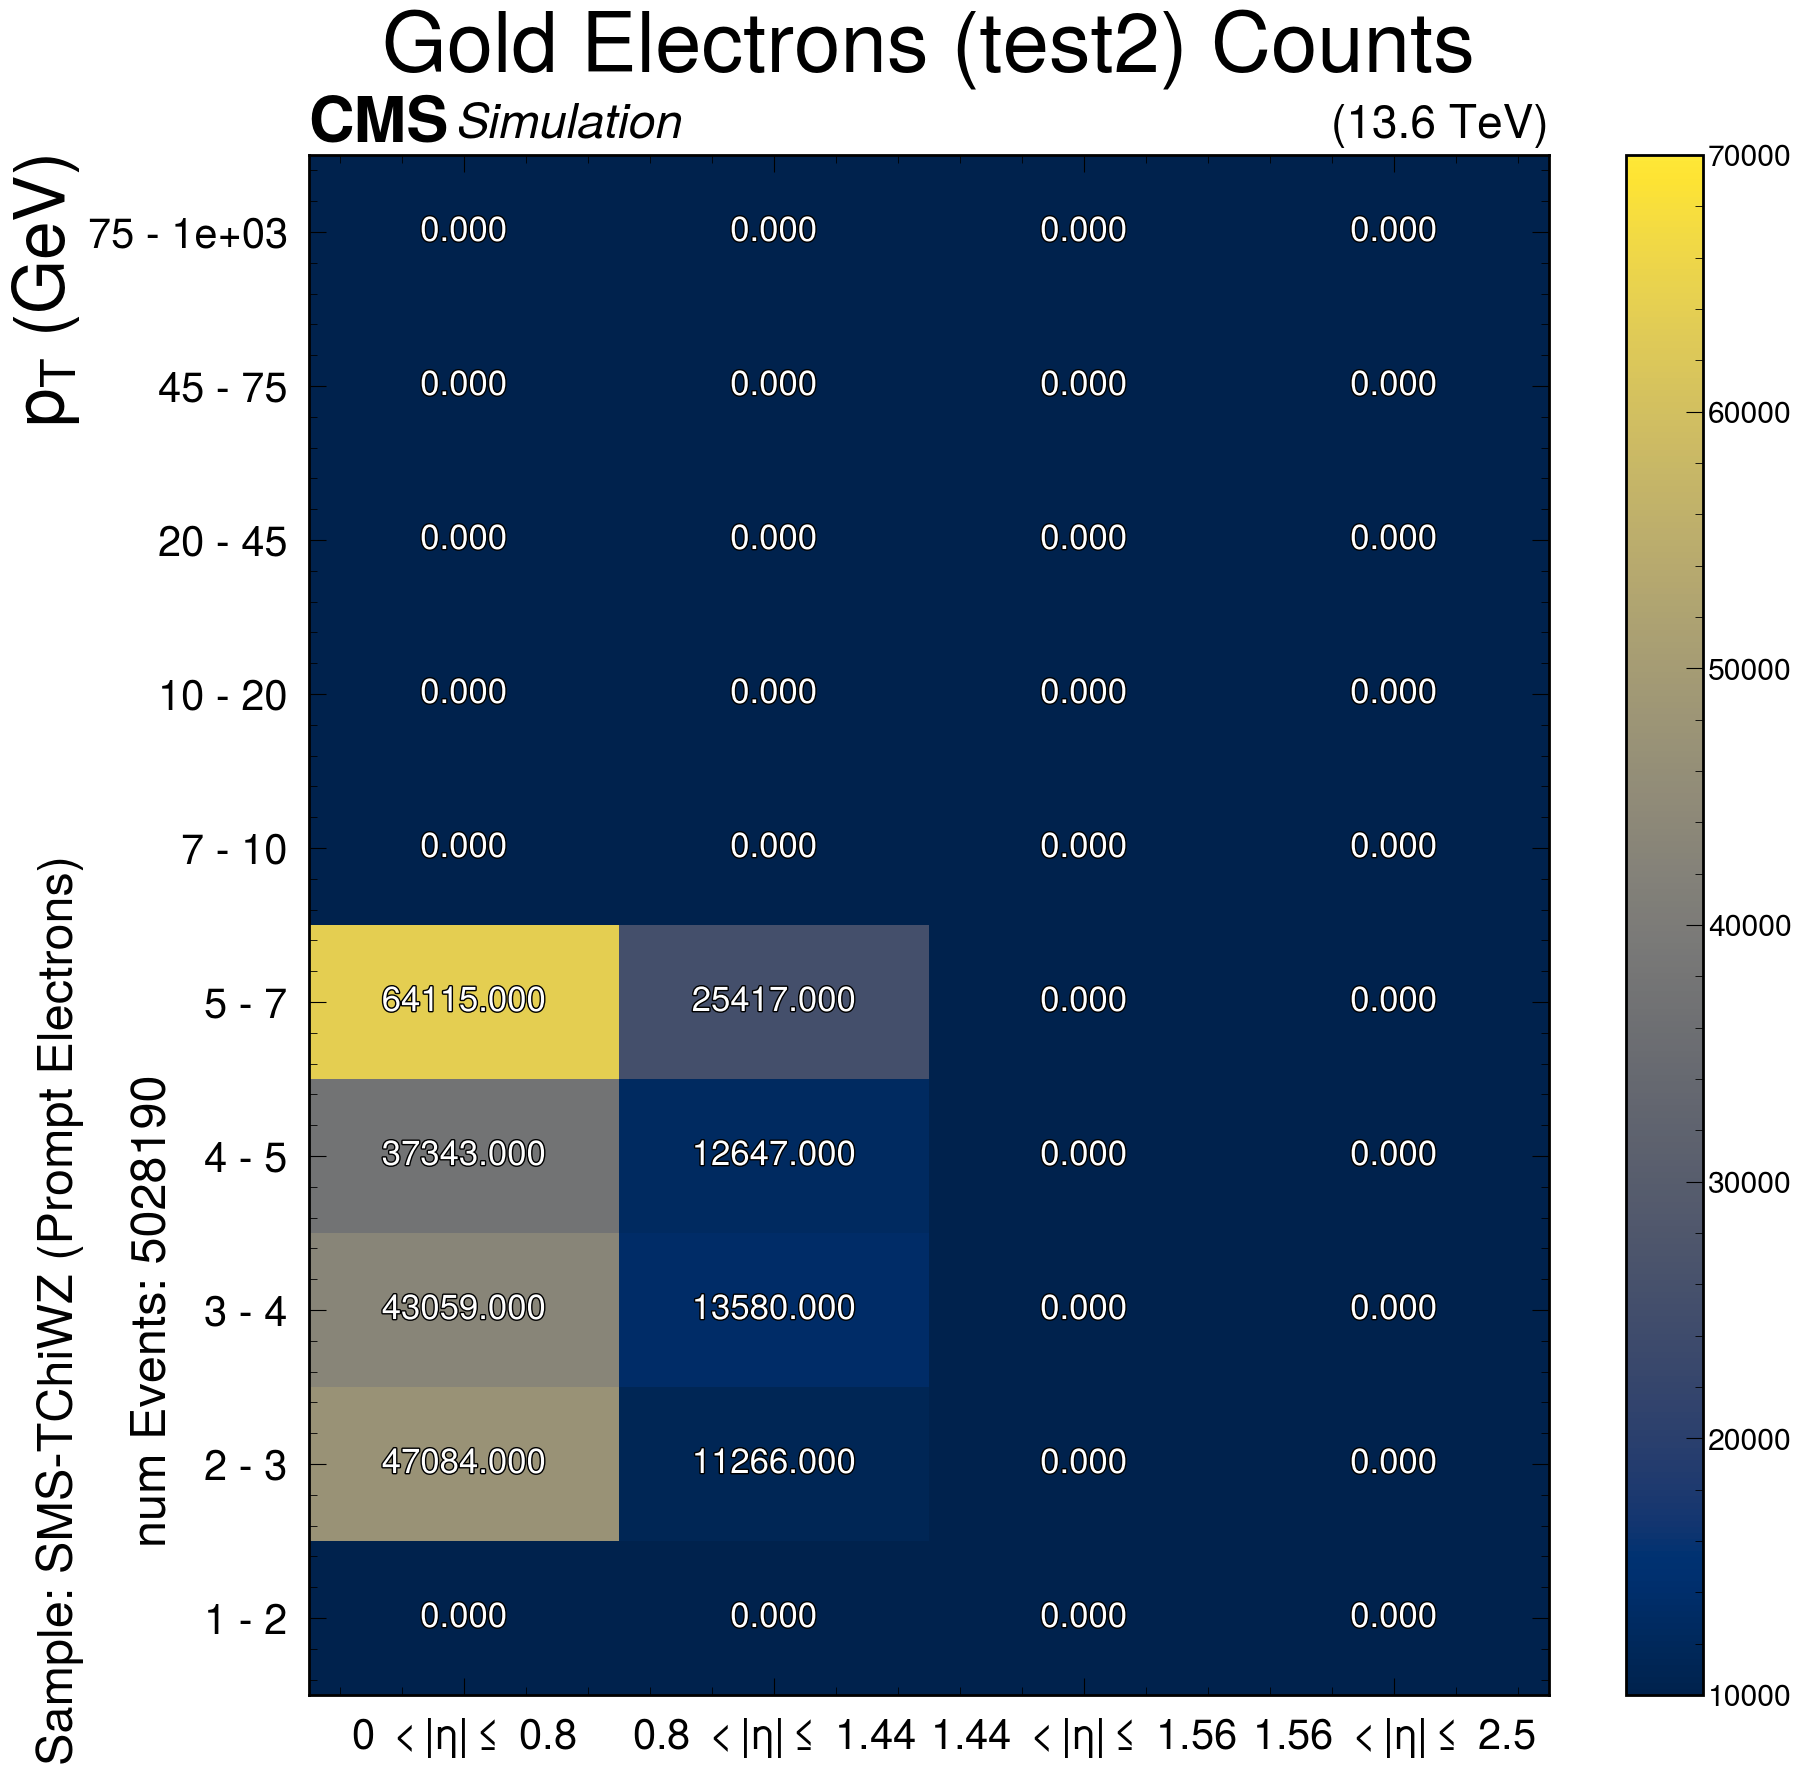

In [44]:
signal_gold = results[list(results.keys())[0]]['lpte_dict']['pt_eta_hist'][:,:, 10j, 3j]

plot_eta_pt_counts(
    signal_gold, 
    title="Gold Electrons (test2)",
    source="(Prompt Electrons)",
    sample_name=list(results.keys())[0][:10],
    save_name="test2_counts_TChiWZ_prompt",
    color="cividis",
    vmin=10000, vmax=70000,
    event_count=results[list(results.keys())[0]]['total_entries']
)

[   1.    2.    3.    4.    5.    7.   10.   20.   45.   75. 1000.]
['1 - 2', '2 - 3', '3 - 4', '4 - 5', '5 - 7', '7 - 10', '10 - 20', '20 - 45', '45 - 75', '75 - 1e+03']
range(0, 11)
[0.     0.8    1.4442 1.556  2.5   ]
['0 $< |\\eta| \\leq$ 0.8', '0.8 $< |\\eta| \\leq$ 1.44', '1.44 $< |\\eta| \\leq$ 1.56', '1.56 $< |\\eta| \\leq$ 2.5']
range(0, 5)


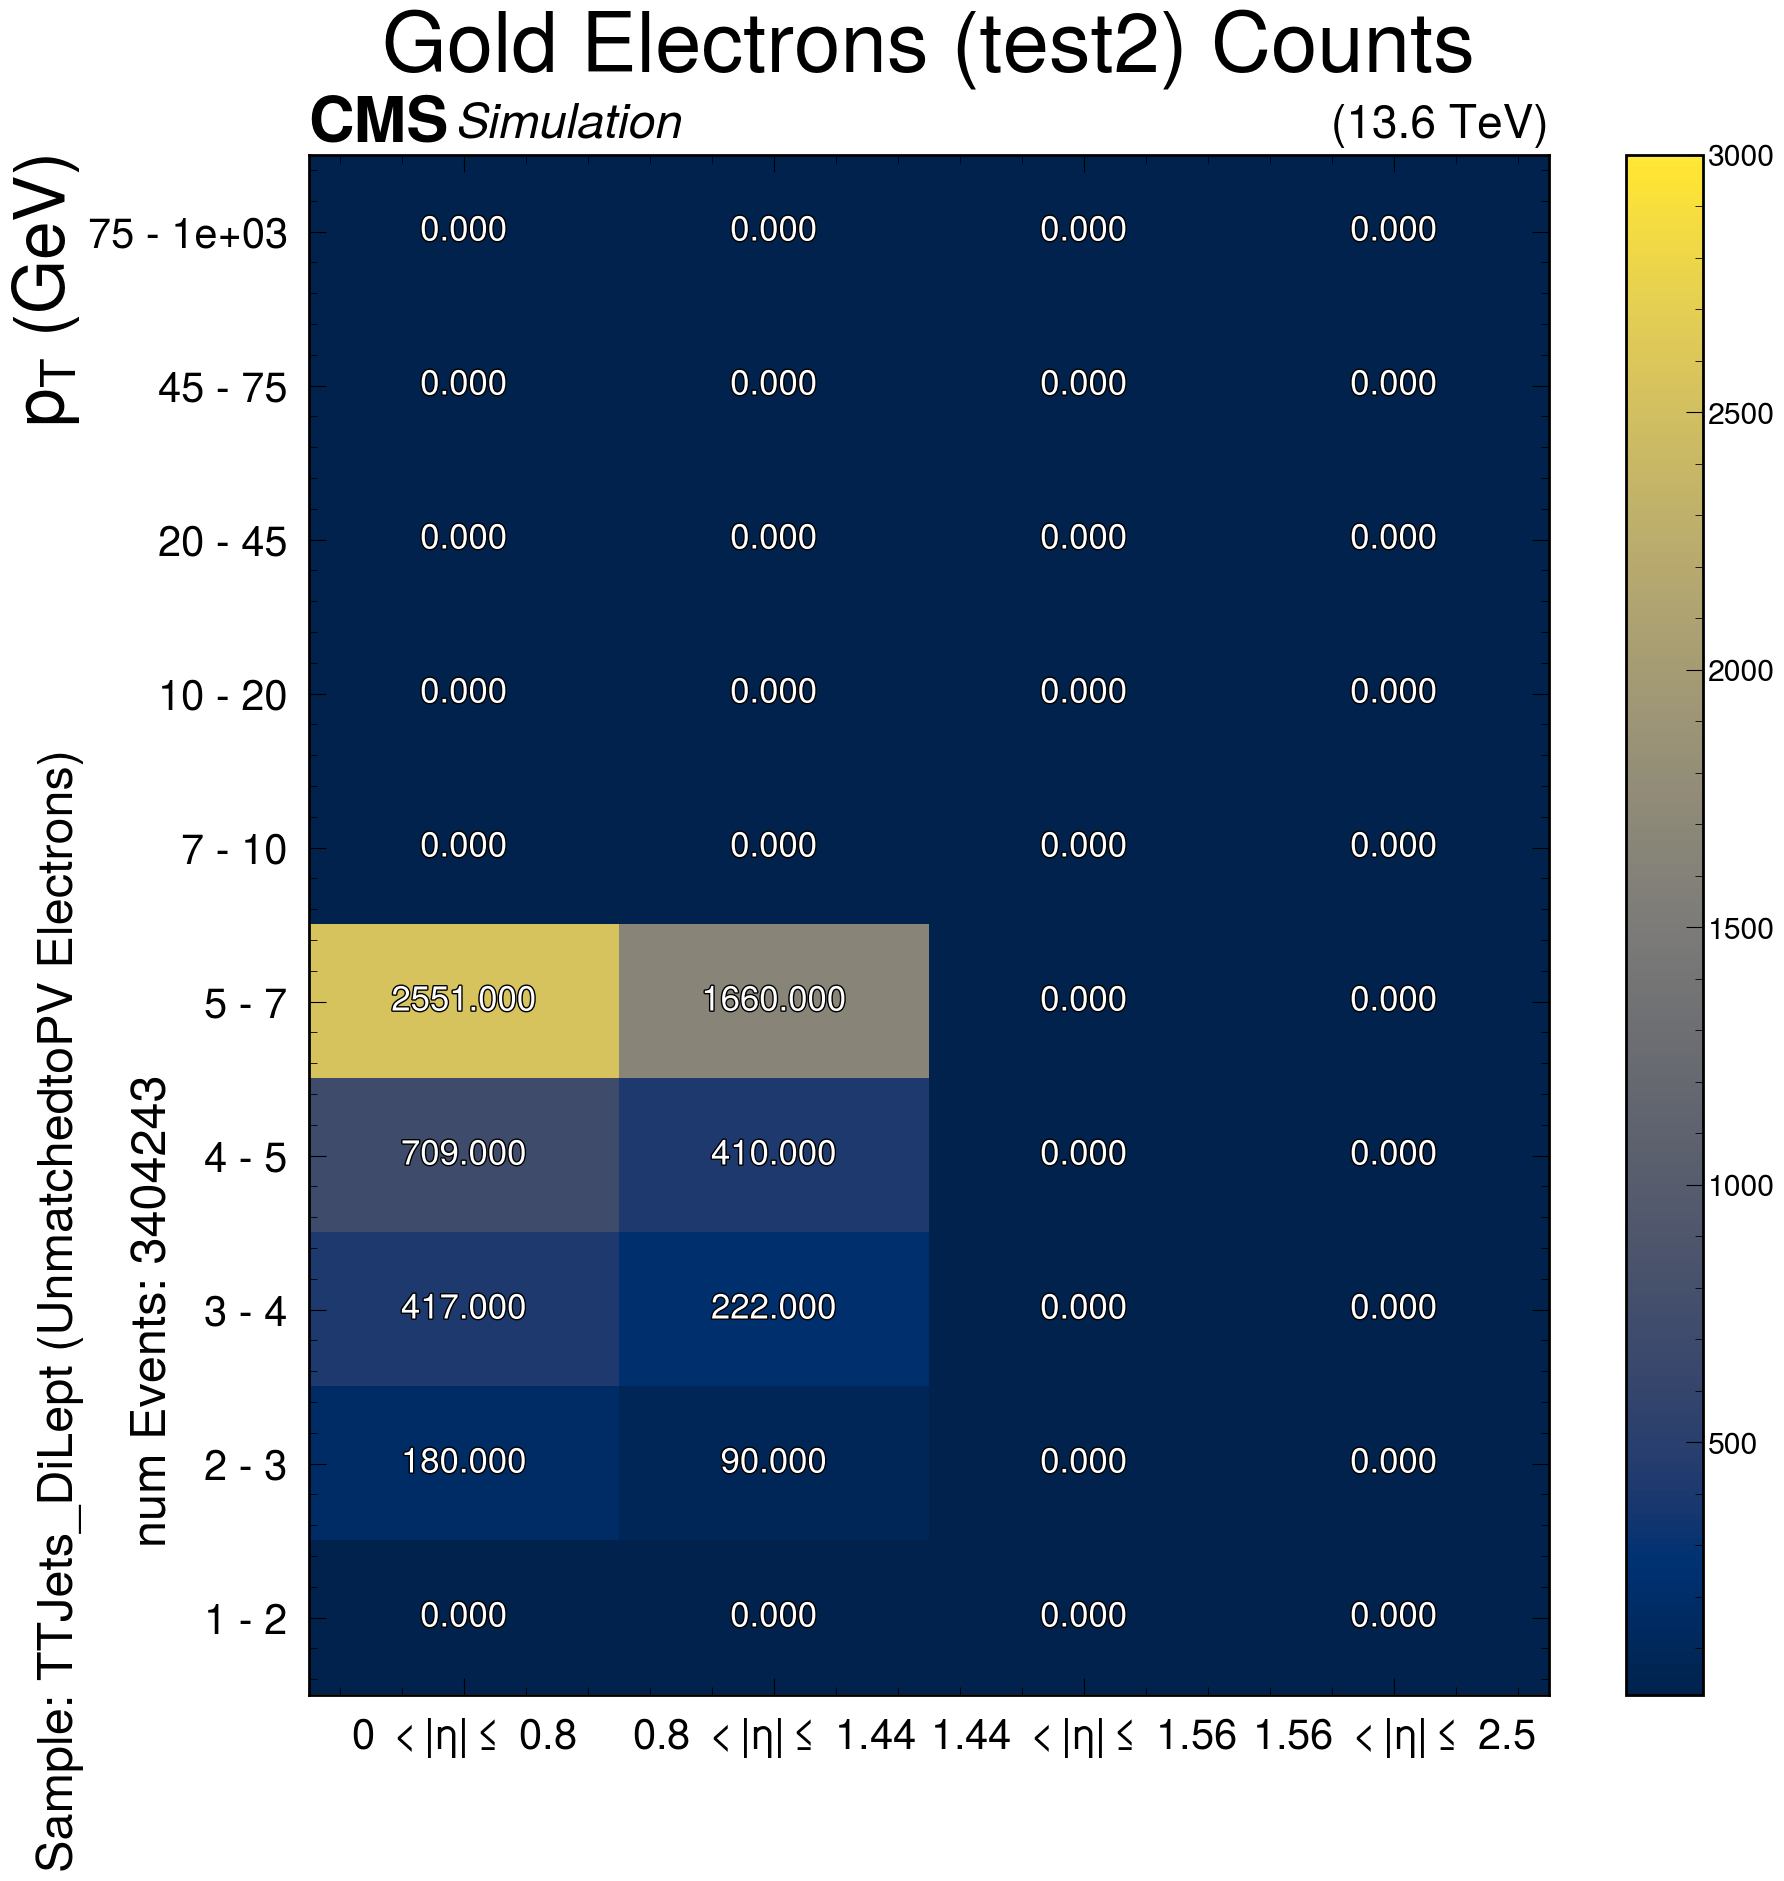

In [45]:
fakes_gold = results[list(results.keys())[1]]['lpte_dict']['pt_eta_hist'][:,:, 10j, 3j]

plot_eta_pt_counts(
    fakes_gold, 
    title="Gold Electrons (test2)",
    source="(UnmatchedtoPV Electrons)",
    sample_name=list(results.keys())[1][:13],
    save_name="test2_counts_TTtoDiJets_unmatched",
    color="cividis",
    vmin=10, vmax=3000,
    event_count=results[list(results.keys())[1]]['total_entries']
)

In [46]:
baseline_signal = results[list(results.keys())[0]]['lpte_dict']['pt_eta_hist'].integrate("qual_tag", [1j,2j,3j])[:,:, 10j]

baseline_signal.values().sum()

340064.0

### baseline signal

current: 367128.0

test2: 340064.0

In [53]:
340064.0 / 367128.0

0.926281841755464

In [47]:
baseline_fakes = results[list(results.keys())[1]]['lpte_dict']['pt_eta_hist'].integrate("qual_tag", [1j,2j,3j])[:,:, 11j]

baseline_fakes.values().sum()

23557.0

### baseline fakes

current: 38047.0

test2: 23557.0

In [52]:
23557.0 / 38047.0

0.6191552553420769

In [55]:
import numpy as np
340064.0 / np.sqrt(23557.0)

2215.647503897531

In [ ]:
2215.647503897531